## SP III-1 Prüfungsleistung - Einführung

Es liegen Daten aus dem Zensus 2022 vor, die für Analysen vorbereitet werden sollen.
Spezifisch soll die Auswertbarkeit nach Ländern und Regionalebene ermöglicht werden. Im Folgenden wird der ETL-Prozess dargestellt mit dem Zensusdaten aus einer Excel-Datei extrahiert, bereinigt und in ein Sternschema für eine PostgreSQL-Datenbank überführt werden. Der Fokus liegt darauf, eine Datenstruktur zu entwickeln, die schnelle und effiziente analytische Abfragen ermöglicht.
Erste visuelle Analysen werden als Abschluss präsentiert.

## 1. Dateninfastruktur aufsetzen

1. PostgreSQL Server lokal aufsetzen
- Authentifizierung und Herstellung einer Datenbanksitzung in PostgreSQL über die psql-Konsole.
- PostgreSQL-Datenbank und Benutzer konfigurieren

2. VS Code und Python
3. pgAdmin für die Verwaltung

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, Table, Column, Integer, String, Float, MetaData, ForeignKey, text
import numpy as np
from psycopg2 import sql
import sweetviz as sv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import locale
from IPython.display import display

## 2. Überführung der Daten in eine relationale Datenbank 

## A. Extract
Extrahieren von 10 Tabellenblättern aus einer Excel-Datei, die in der Benennung mit "CSV-" beginnen sowie des erstellten Attribute_Details Arbeitsblattes.

In [2]:
# Basispfade und Dateinamen
base_path = '/Users/sabinewildemann/Desktop/Studium/DAI92-SPIII-1-Dateninfrastruktur_wildemann/'
input_path = os.path.join(base_path, 'input')
output_path = os.path.join(base_path, 'output')
file_name = "Regionaltabelle_Bildung_Erwerbstaetigkeit 1.xlsx"
file_path = os.path.join(input_path, file_name)

# Einlesen der Excel-Datei
xls = pd.ExcelFile(file_path)

# Einlesen und Laden der Attribute Details
attribute_details_df = xls.parse('Attribute_Details')
attribute_details_df['attribut_id'] = range(1, len(attribute_details_df) + 1)

# Attribute Details in einem Dictionary speichern für schnellen Zugriff
attribute_details_dict = dict(zip(attribute_details_df['Attribut'], attribute_details_df['attribut_id']))

# Datenframes für die Daten und Attribute vorbereiten
data_frames = {}

# Festlegen, welche Sheets ausgelesen werden sollen
sheets_to_read = [sheet for sheet in xls.sheet_names if sheet.startswith("CSV-")]

# Daten für jede Entität einlesen und verarbeiten
for sheet_name in sheets_to_read:
    df = xls.parse(sheet_name, dtype={'_RS': str})
    clean_name = sheet_name.replace("CSV-", "")
    
    # Definieren der Muster, die für Summenspalten stehen und daher ausgeschlossen werden sollen
    summen_spalten_muster = ('_STP', '_STP__M', '_STP__W', '_ERW', '_ERW__M', '_ERW__W')

    # Anpassen des DataFrame, indem alle Spalten, die auf die definierten Muster enden, ausgeschlossen werden
    df = df[[col for col in df.columns if not col.endswith(summen_spalten_muster)]]
    
    # Hinzufügen von Attributdetails und Entität-Name
    df['Entität'] = clean_name
    for col in df.columns:
        if col in attribute_details_dict:
            df[col + '_detail'] = attribute_details_dict[col]

    data_frames[clean_name] = df
    
# Anzahl der geladenen Tabellen und deren Namen ausgeben
print(f"Anzahl der geladenen Tabellen: {len(sheets_to_read)}")
print(f"Geladene Tabellen und entsprechende DataFrame-Namen: {list(data_frames.keys())}")

# Überprüfung der Daten
for sheet, df in data_frames.items():
    print(f"\nDatenüberprüfung für {sheet}:")
    display(df.head(10))   


Anzahl der geladenen Tabellen: 10
Geladene Tabellen und entsprechende DataFrame-Namen: ['Klassenstufe', 'Schulform', 'Hoechster_Schulabschluss', 'Hoechster_berufl_Abschluss', 'Erwerbsstatus', 'ET_Alter', 'ET_Hoechst_berufl_Abschl', 'ET_Stellung_im_Beruf', 'ET_Beruf_Hauptgr_ISCO08', 'ET_Wirtschaftszweig']

Datenüberprüfung für Klassenstufe:


,Berichtszeitpunkt,_RS,Name,Regionalebene,SCHUELER_KLSS_STP__1,SCHUELER_KLSS_STP__1_M,SCHUELER_KLSS_STP__1_W,SCHUELER_KLSS_STP__2,SCHUELER_KLSS_STP__2_M,SCHUELER_KLSS_STP__2_W,SCHUELER_KLSS_STP__3,SCHUELER_KLSS_STP__3_M,SCHUELER_KLSS_STP__3_W,Entität
0,20220515,00,Deutschland,Bund,3048570,1563180,1485400,4490850,2324270,2166580,1364360,648590,715760,Klassenstufe
1,20220515,01,Schleswig-Holstein,Land,109240,54930,54310,161100,83860,77240,49720,24090,25630,Klassenstufe
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3530,1540,1990,5030,2700,2330,1820,770,1060,Klassenstufe
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,3530,1540,1990,5030,2700,2330,1820,770,1060,Klassenstufe
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,8770,4180,4590,11180,5810,5360,4400,2280,2120,Klassenstufe
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,8770,4180,4590,11180,5810,5360,4400,2280,2120,Klassenstufe
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,7420,3810,3610,10740,5520,5220,3150,1550,1600,Klassenstufe
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,7420,3810,3610,10740,5520,5220,3150,1550,1600,Klassenstufe
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,2710,1420,1300,4860,2590,2270,1260,720,540,Klassenstufe
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,2710,1420,1300,4860,2590,2270,1260,720,540,Klassenstufe



Datenüberprüfung für Schulform:


,Berichtszeitpunkt,_RS,Name,Regionalebene,SCHUELER_SCH_STP__1,SCHUELER_SCH_STP__1_M,SCHUELER_SCH_STP__1_W,SCHUELER_SCH_STP__2,SCHUELER_SCH_STP__2_M,SCHUELER_SCH_STP__2_W,...,SCHUELER_SCH_STP__5,SCHUELER_SCH_STP__5_M,SCHUELER_SCH_STP__5_W,SCHUELER_SCH_STP__6,SCHUELER_SCH_STP__6_M,SCHUELER_SCH_STP__6_W,SCHUELER_SCH_STP__7,SCHUELER_SCH_STP__7_M,SCHUELER_SCH_STP__7_W,Entität
0,20220515,00,Deutschland,Bund,3033030,1544890,1488150,231290,147550,83740,...,1251860,654280,597590,838400,433130,405270,2594630,1240010,1354630,Schulform
1,20220515,01,Schleswig-Holstein,Land,105520,52830,52690,5680,3870,1800,...,16560,8850,7710,60880,31750,29130,92830,45050,47780,Schulform
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3320,1380,1940,340,270,/,...,620,390,230,1980,1100,880,3040,1360,1680,Schulform
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,3320,1380,1940,340,270,/,...,620,390,230,1980,1100,880,3040,1360,1680,Schulform
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,8280,3910,4370,310,/,/,...,1090,560,540,4250,2500,1760,7690,3580,4110,Schulform
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,8280,3910,4370,310,/,/,...,1090,560,540,4250,2500,1760,7690,3580,4110,Schulform
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,7210,3740,3470,460,320,/,...,1170,570,600,3930,1840,2090,6140,3270,2870,Schulform
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,7210,3740,3470,460,320,/,...,1170,570,600,3930,1840,2090,6140,3270,2870,Schulform
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,2530,1340,1190,320,230,/,...,400,250,/,2200,940,1260,2300,1330,970,Schulform
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,2530,1340,1190,320,230,/,...,400,250,/,2200,940,1260,2300,1330,970,Schulform



Datenüberprüfung für Hoechster_Schulabschluss:


,Berichtszeitpunkt,_RS,Name,Regionalebene,SCHULABS_STP__1,SCHULABS_STP__1_M,SCHULABS_STP__1_W,SCHULABS_STP__2,SCHULABS_STP__2_M,SCHULABS_STP__2_W,...,SCHULABS_STP__23,SCHULABS_STP__23_M,SCHULABS_STP__23_W,SCHULABS_STP__24,SCHULABS_STP__24_M,SCHULABS_STP__24_W,SCHULABS_STP__3,SCHULABS_STP__3_M,SCHULABS_STP__3_W,Entität
0,20220515,00,Deutschland,Bund,2813430,1422440,1391000,61869570,30110910,31758660,...,16671630,7509810,9161820,24244250,12162150,12082090,4768580,2408490,2360090,Hoechster_Schulabschluss
1,20220515,01,Schleswig-Holstein,Land,103590,52550,51040,2252550,1087850,1164710,...,770050,345230,424820,805860,401690,404180,116990,60190,56810,Hoechster_Schulabschluss
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3590,1750,1830,71000,34810,36190,...,20330,9370,10960,30650,16000,14650,5410,2830,2580,Hoechster_Schulabschluss
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,3590,1750,1830,71000,34810,36190,...,20330,9370,10960,30650,16000,14650,5410,2830,2580,Hoechster_Schulabschluss
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,8570,4480,4090,190440,92530,97910,...,48090,21480,26610,99230,49690,49540,13680,6780,6900,Hoechster_Schulabschluss
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,8570,4480,4090,190440,92530,97910,...,48090,21480,26610,99230,49690,49540,13680,6780,6900,Hoechster_Schulabschluss
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,6970,3540,3440,164510,77890,86630,...,49330,21500,27830,65430,32590,32840,10890,5240,5650,Hoechster_Schulabschluss
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,6970,3540,3440,164510,77890,86630,...,49330,21500,27830,65430,32590,32840,10890,5240,5650,Hoechster_Schulabschluss
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3110,1730,1380,58580,28580,29990,...,19250,8970,10280,16940,8480,8450,5240,2580,2660,Hoechster_Schulabschluss
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,3110,1730,1380,58580,28580,29990,...,19250,8970,10280,16940,8480,8450,5240,2580,2660,Hoechster_Schulabschluss



Datenüberprüfung für Hoechster_berufl_Abschluss:


,Berichtszeitpunkt,_RS,Name,Regionalebene,BERUFABS_AUSF_STP__1,BERUFABS_AUSF_STP__1_M,BERUFABS_AUSF_STP__1_W,BERUFABS_AUSF_STP__11,BERUFABS_AUSF_STP__11_M,BERUFABS_AUSF_STP__11_W,...,BERUFABS_AUSF_STP__16,BERUFABS_AUSF_STP__16_M,BERUFABS_AUSF_STP__16_W,BERUFABS_AUSF_STP__17,BERUFABS_AUSF_STP__17_M,BERUFABS_AUSF_STP__17_W,BERUFABS_AUSF_STP__2,BERUFABS_AUSF_STP__2_M,BERUFABS_AUSF_STP__2_W,Entität
0,20220515,00,Deutschland,Bund,50585600,25157920,25427680,28070250,13963090,14107150,...,8176080,4311610,3864470,1146250,720310,425940,18865980,8783920,10082070,Hoechster_berufl_Abschluss
1,20220515,01,Schleswig-Holstein,Land,1885180,930860,954310,1225220,602340,622880,...,275740,147790,127960,29610,17920,11680,587950,269720,318240,Hoechster_berufl_Abschluss
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,55910,28070,27840,33590,17070,16520,...,9140,4860,4280,690,410,280,24090,11330,12760,Hoechster_berufl_Abschluss
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,55910,28070,27840,33590,17070,16520,...,9140,4860,4280,690,410,280,24090,11330,12760,Hoechster_berufl_Abschluss
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,149880,73350,76530,80410,39280,41130,...,28390,14770,13620,4940,2950,1990,62810,30430,32380,Hoechster_berufl_Abschluss
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,149880,73350,76530,80410,39280,41130,...,28390,14770,13620,4940,2950,1990,62810,30430,32380,Hoechster_berufl_Abschluss
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,132870,64090,68790,81290,39570,41720,...,22030,11620,10410,2910,1740,1170,49500,22580,26920,Hoechster_berufl_Abschluss
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,132870,64090,68790,81290,39570,41720,...,22030,11620,10410,2910,1740,1170,49500,22580,26920,Hoechster_berufl_Abschluss
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,47680,24020,23660,33440,17210,16240,...,5090,2770,2320,490,270,210,19240,8870,10370,Hoechster_berufl_Abschluss
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,47680,24020,23660,33440,17210,16240,...,5090,2770,2320,490,270,210,19240,8870,10370,Hoechster_berufl_Abschluss



Datenüberprüfung für Erwerbsstatus:


,Berichtszeitpunkt,_RS,Name,Regionalebene,ERWERBSTAT_KURZ_STP__1,ERWERBSTAT_KURZ_STP__1_M,ERWERBSTAT_KURZ_STP__1_W,ERWERBSTAT_KURZ_STP__11,ERWERBSTAT_KURZ_STP__11_M,ERWERBSTAT_KURZ_STP__11_W,ERWERBSTAT_KURZ_STP__12,ERWERBSTAT_KURZ_STP__12_M,ERWERBSTAT_KURZ_STP__12_W,ERWERBSTAT_KURZ_STP__2,ERWERBSTAT_KURZ_STP__2_M,ERWERBSTAT_KURZ_STP__2_W,Entität
0,20220515,00,Deutschland,Bund,43758350,23001730,20756620,41047770,21622700,19425070,2710580,1379030,1331550,37031860,16754970,20276900,Erwerbsstatus
1,20220515,01,Schleswig-Holstein,Land,1585940,824160,761780,1479510,773840,705670,106430,50320,56110,1278370,577060,701310,Erwerbsstatus
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,52900,28410,24490,48070,26040,22030,4830,2360,2460,39170,17060,22110,Erwerbsstatus
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,52900,28410,24490,48070,26040,22030,4830,2360,2460,39170,17060,22110,Erwerbsstatus
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,139920,72500,67420,128800,67060,61740,11120,5440,5680,103510,46860,56650,Erwerbsstatus
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,139920,72500,67420,128800,67060,61740,11120,5440,5680,103510,46860,56650,Erwerbsstatus
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,113940,58640,55300,104830,54440,50390,9120,4200,4910,95130,42070,53060,Erwerbsstatus
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,113940,58640,55300,104830,54440,50390,9120,4200,4910,95130,42070,53060,Erwerbsstatus
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,41390,22090,19310,38430,20760,17680,2960,1330,1630,35620,16040,19590,Erwerbsstatus
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,41390,22090,19310,38430,20760,17680,2960,1330,1630,35620,16040,19590,Erwerbsstatus



Datenüberprüfung für ET_Alter:


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_ALTER_ERW__1,ET_ALTER_ERW__1_M,ET_ALTER_ERW__1_W,ET_ALTER_ERW__2,ET_ALTER_ERW__2_M,ET_ALTER_ERW__2_W,...,ET_ALTER_ERW__5,ET_ALTER_ERW__5_M,ET_ALTER_ERW__5_W,ET_ALTER_ERW__6,ET_ALTER_ERW__6_M,ET_ALTER_ERW__6_W,ET_ALTER_ERW__7,ET_ALTER_ERW__7_M,ET_ALTER_ERW__7_W,Entität
0,20220515,00,Deutschland,Bund,1150950,601280,549660,6695970,3536140,3159830,...,10567270,5473450,5093820,4503560,2359280,2144280,1025860,604330,421530,ET_Alter
1,20220515,01,Schleswig-Holstein,Land,43110,22130,20990,233760,125440,108320,...,408640,209070,199570,165800,86770,79030,38700,23580,15120,ET_Alter
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,1190,660,540,11760,6150,5620,...,10530,5490,5030,4550,2500,2050,1160,710,450,ET_Alter
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,1190,660,540,11760,6150,5620,...,10530,5490,5030,4550,2500,2050,1160,710,450,ET_Alter
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,3900,1800,2100,31210,15830,15380,...,27330,13800,13530,11580,5790,5790,2360,1510,850,ET_Alter
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,3900,1800,2100,31210,15830,15380,...,27330,13800,13530,11580,5790,5790,2360,1510,850,ET_Alter
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,3100,1660,1440,19220,10140,9070,...,26490,13940,12550,10490,5110,5380,2280,1430,850,ET_Alter
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,3100,1660,1440,19220,10140,9070,...,26490,13940,12550,10490,5110,5380,2280,1430,850,ET_Alter
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,1000,540,460,6860,3770,3090,...,10150,5130,5020,4410,2460,1950,930,520,410,ET_Alter
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,1000,540,460,6860,3770,3090,...,10150,5130,5020,4410,2460,1950,930,520,410,ET_Alter



Datenüberprüfung für ET_Hoechst_berufl_Abschl:


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_BERUFABS_KURZ_STP__1,ET_BERUFABS_KURZ_STP__1_M,ET_BERUFABS_KURZ_STP__1_W,ET_BERUFABS_KURZ_STP__11,ET_BERUFABS_KURZ_STP__11_M,ET_BERUFABS_KURZ_STP__11_W,ET_BERUFABS_KURZ_STP__12,ET_BERUFABS_KURZ_STP__12_M,ET_BERUFABS_KURZ_STP__12_W,ET_BERUFABS_KURZ_STP__13,ET_BERUFABS_KURZ_STP__13_M,ET_BERUFABS_KURZ_STP__13_W,ET_BERUFABS_KURZ_STP__2,ET_BERUFABS_KURZ_STP__2_M,ET_BERUFABS_KURZ_STP__2_W,Entität
0,20220515,00,Deutschland,Bund,32511190,16932090,15579100,16704500,9011580,7692920,5493720,2514800,2978920,10312980,5405710,4907270,8536580,4690610,3845970,ET_Hoechst_berufl_Abschl
1,20220515,01,Schleswig-Holstein,Land,1208310,626220,582080,743800,394610,349190,143200,63000,80200,321310,168610,152690,271200,147610,123590,ET_Hoechst_berufl_Abschl
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,35970,19160,16820,20040,11170,8870,3980,1830,2140,11950,6160,5800,12100,6890,5210,ET_Hoechst_berufl_Abschl
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,35970,19160,16820,20040,11170,8870,3980,1830,2140,11950,6160,5800,12100,6890,5210,ET_Hoechst_berufl_Abschl
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,97680,50070,47610,46570,24930,21640,9350,3730,5610,41770,21400,20360,31120,16990,14120,ET_Hoechst_berufl_Abschl
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,97680,50070,47610,46570,24930,21640,9350,3730,5610,41770,21400,20360,31120,16990,14120,ET_Hoechst_berufl_Abschl
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,82890,42210,40680,46470,24700,21770,9610,3260,6360,26810,14260,12550,21940,12230,9710,ET_Hoechst_berufl_Abschl
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,82890,42210,40680,46470,24700,21770,9610,3260,6360,26810,14260,12550,21940,12230,9710,ET_Hoechst_berufl_Abschl
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,30170,16000,14180,20160,11230,8930,4150,1630,2520,5870,3140,2730,8260,4760,3500,ET_Hoechst_berufl_Abschl
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,30170,16000,14180,20160,11230,8930,4150,1630,2520,5870,3140,2730,8260,4760,3500,ET_Hoechst_berufl_Abschl



Datenüberprüfung für ET_Stellung_im_Beruf:


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_STELLGBERF_STP__1,ET_STELLGBERF_STP__1_M,ET_STELLGBERF_STP__1_W,ET_STELLGBERF_STP__2,ET_STELLGBERF_STP__2_M,ET_STELLGBERF_STP__2_W,ET_STELLGBERF_STP__3,ET_STELLGBERF_STP__3_M,ET_STELLGBERF_STP__3_W,ET_STELLGBERF_STP__4,ET_STELLGBERF_STP__4_M,ET_STELLGBERF_STP__4_W,ET_STELLGBERF_STP__5,ET_STELLGBERF_STP__5_M,ET_STELLGBERF_STP__5_W,Entität
0,20220515,00,Deutschland,Bund,35136770,18141720,16995050,2103730,1047640,1056090,1937560,1381550,556020,1598280,940180,658100,271430,111610,159820,ET_Stellung_im_Beruf
1,20220515,01,Schleswig-Holstein,Land,1243900,630670,613230,85660,46740,38920,83740,59120,24610,56440,33410,23030,9770,3890,5890,ET_Stellung_im_Beruf
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,40790,21710,19090,3240,1870,1360,2140,1450,690,1840,990,850,/,/,/,ET_Stellung_im_Beruf
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,40790,21710,19090,3240,1870,1360,2140,1450,690,1840,990,850,/,/,/,ET_Stellung_im_Beruf
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,110400,56060,54340,8870,4780,4090,5020,3530,1480,3990,2480,1510,530,/,320,ET_Stellung_im_Beruf
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,110400,56060,54340,8870,4780,4090,5020,3530,1480,3990,2480,1510,530,/,320,ET_Stellung_im_Beruf
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,89220,44950,44270,5860,3300,2560,5300,3590,1710,4110,2450,1650,340,/,/,ET_Stellung_im_Beruf
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,89220,44950,44270,5860,3300,2560,5300,3590,1710,4110,2450,1650,340,/,/,ET_Stellung_im_Beruf
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,33720,17560,16160,1790,1030,760,1450,1180,270,1360,920,440,/,/,/,ET_Stellung_im_Beruf
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,33720,17560,16160,1790,1030,760,1450,1180,270,1360,920,440,/,/,/,ET_Stellung_im_Beruf



Datenüberprüfung für ET_Beruf_Hauptgr_ISCO08:


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_BERUFSKLSS_HGISCO_STP__1,ET_BERUFSKLSS_HGISCO_STP__1_M,ET_BERUFSKLSS_HGISCO_STP__1_W,ET_BERUFSKLSS_HGISCO_STP__2,ET_BERUFSKLSS_HGISCO_STP__2_M,ET_BERUFSKLSS_HGISCO_STP__2_W,...,ET_BERUFSKLSS_HGISCO_STP__8,ET_BERUFSKLSS_HGISCO_STP__8_M,ET_BERUFSKLSS_HGISCO_STP__8_W,ET_BERUFSKLSS_HGISCO_STP__9,ET_BERUFSKLSS_HGISCO_STP__9_M,ET_BERUFSKLSS_HGISCO_STP__9_W,ET_BERUFSKLSS_HGISCO_STP__0,ET_BERUFSKLSS_HGISCO_STP__0_M,ET_BERUFSKLSS_HGISCO_STP__0_W,Entität
0,20220515,00,Deutschland,Bund,1877180,1286960,590220,9040890,4461000,4579890,...,2297460,1936810,360650,2996680,1360890,1635790,151210,133280,17930,ET_Beruf_Hauptgr_ISCO08
1,20220515,01,Schleswig-Holstein,Land,68240,46110,22140,282860,135380,147480,...,71610,61220,10390,105530,47700,57820,11950,10380,1570,ET_Beruf_Hauptgr_ISCO08
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,2160,1440,710,10330,4840,5490,...,2310,1850,460,4970,2420,2550,780,620,/,ET_Beruf_Hauptgr_ISCO08
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,2160,1440,710,10330,4840,5490,...,2310,1850,460,4970,2420,2550,780,620,/,ET_Beruf_Hauptgr_ISCO08
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,4880,3260,1610,35450,17330,18120,...,4660,4070,590,9640,4720,4920,1160,930,240,ET_Beruf_Hauptgr_ISCO08
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,4880,3260,1610,35450,17330,18120,...,4660,4070,590,9640,4720,4920,1160,930,240,ET_Beruf_Hauptgr_ISCO08
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,4640,3060,1580,25060,12560,12490,...,5830,4620,1210,8150,3710,4440,310,310,/,ET_Beruf_Hauptgr_ISCO08
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,4640,3060,1580,25060,12560,12490,...,5830,4620,1210,8150,3710,4440,310,310,/,ET_Beruf_Hauptgr_ISCO08
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,1470,980,490,5020,2680,2340,...,2400,2210,/,3900,1890,2010,220,/,/,ET_Beruf_Hauptgr_ISCO08
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,1470,980,490,5020,2680,2340,...,2400,2210,/,3900,1890,2010,220,/,/,ET_Beruf_Hauptgr_ISCO08



Datenüberprüfung für ET_Wirtschaftszweig:


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_WIRTSZWG_STP__1,ET_WIRTSZWG_STP__1_M,ET_WIRTSZWG_STP__1_W,ET_WIRTSZWG_STP__2,ET_WIRTSZWG_STP__2_M,ET_WIRTSZWG_STP__2_W,...,ET_WIRTSZWG_STP__34,ET_WIRTSZWG_STP__34_M,ET_WIRTSZWG_STP__34_W,ET_WIRTSZWG_STP__35,ET_WIRTSZWG_STP__35_M,ET_WIRTSZWG_STP__35_W,ET_WIRTSZWG_STP__36,ET_WIRTSZWG_STP__36_M,ET_WIRTSZWG_STP__36_W,Entität
0,20220515,00,Deutschland,Bund,789080,534120,254960,10919270,8315160,2604110,...,2874220,1552910,1321320,2995340,1399930,1595410,12115170,3566500,8548660,ET_Wirtschaftszweig
1,20220515,01,Schleswig-Holstein,Land,50420,34920,15510,332210,256660,75550,...,82730,48350,34380,137240,69430,67810,402150,107770,294370,ET_Wirtschaftszweig
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,740,520,220,9760,7280,2480,...,2850,1750,1100,3990,2130,1860,14560,4810,9750,ET_Wirtschaftszweig
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,740,520,220,9760,7280,2480,...,2850,1750,1100,3990,2130,1860,14560,4810,9750,ET_Wirtschaftszweig
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,1510,960,550,20440,15950,4490,...,10030,6070,3960,15100,7770,7340,41660,12850,28810,ET_Wirtschaftszweig
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,1510,960,550,20440,15950,4490,...,10030,6070,3960,15100,7770,7340,41660,12850,28810,ET_Wirtschaftszweig
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,1390,1130,250,22000,16510,5490,...,6670,4120,2550,9010,4710,4300,33340,10320,23020,ET_Wirtschaftszweig
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,1390,1130,250,22000,16510,5490,...,6670,4120,2550,9010,4710,4300,33340,10320,23020,ET_Wirtschaftszweig
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,580,470,/,8600,6870,1730,...,1910,1020,880,3200,1490,1710,9820,2640,7180,ET_Wirtschaftszweig
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,580,470,/,8600,6870,1730,...,1910,1020,880,3200,1490,1710,9820,2640,7180,ET_Wirtschaftszweig


### Cleansing und Profiling report

In [3]:
#Lt. Erläuterungen zur Methodik in der Zensus 2022_Datei gibt es einige Sonderzeichen, die zu berücksichtigen sind:
#–= Genau Null oder auf Null geändert
#/= Keine Angabe, da Zahlenwert nicht sicher genug
#.= Zahlenwert unbekannt oder geheim

def replace_special_characters(val): 
    if isinstance(val, str):
        # Entferne führende und nachfolgende Leerzeichen
        val = val.strip()
        
        # Prüfe, ob der Wert ein einzelner langer Gedankenstrich ist
        if val == '–':
            return 0
        elif val == '/' or val == '.':
            return np.nan
    
    # Gibt den ursprünglichen Wert zurück, wenn keine Ersetzung erforderlich ist
    return (val)

def count_and_replace_special_characters(df):
    special_chars = ['–', '.', '/']  # Verwende nur die relevanten Sonderzeichen
    counts = {char: 0 for char in special_chars}
    
    for col in df.columns:
        if df[col].dtype == object:
            # Zählen der Sonderzeichen
            for char in special_chars:
                counts[char] += df[col].apply(lambda x: str(x).strip() == char).sum()
            
            # Ersetzen der Sonderzeichen nur, wenn sie allein in einer Zelle stehen
            # YY das aus dem Kommentar wird hier aber nicht gemacht
            df[col] = df[col].apply(replace_special_characters)
        else:
            # Wenn die Spalte numerisch ist, gibt es keine Sonderzeichen
            continue
    
    return counts

# Überprüfe jedes Sheet, zähle die Sonderzeichen und ersetze sie
for sheet, df in data_frames.items():
    special_char_counts = count_and_replace_special_characters(df)
    print(f"Gefundene und ersetzte spezielle Zeichen im DataFrame {sheet}:")
    for char, count in special_char_counts.items():
        print(f"Anzahl von '{char}': {count}")

# Optional: Überprüfung der Ergebnisse
for sheet_name, df in data_frames.items():
    print(f"\nÜberprüfung des DataFrames '{sheet_name}':")
    display(df.head(10))


Gefundene und ersetzte spezielle Zeichen im DataFrame Klassenstufe:
Anzahl von '–': 1
Anzahl von '.': 88308
Anzahl von '/': 4530
Gefundene und ersetzte spezielle Zeichen im DataFrame Schulform:
Anzahl von '–': 1190
Anzahl von '.': 206052
Anzahl von '/': 28721
Gefundene und ersetzte spezielle Zeichen im DataFrame Hoechster_Schulabschluss:
Anzahl von '–': 32
Anzahl von '.': 206052
Anzahl von '/': 6160
Gefundene und ersetzte spezielle Zeichen im DataFrame Hoechster_berufl_Abschluss:
Anzahl von '–': 519
Anzahl von '.': 264924
Anzahl von '/': 16345
Gefundene und ersetzte spezielle Zeichen im DataFrame Erwerbsstatus:
Anzahl von '–': 0
Anzahl von '.': 117744
Anzahl von '/': 1905
Gefundene und ersetzte spezielle Zeichen im DataFrame ET_Alter:
Anzahl von '–': 5
Anzahl von '.': 206052
Anzahl von '/': 8313
Gefundene und ersetzte spezielle Zeichen im DataFrame ET_Hoechst_berufl_Abschl:
Anzahl von '–': 0
Anzahl von '.': 147180
Anzahl von '/': 60
Gefundene und ersetzte spezielle Zeichen im DataFrame

,Berichtszeitpunkt,_RS,Name,Regionalebene,SCHUELER_KLSS_STP__1,SCHUELER_KLSS_STP__1_M,SCHUELER_KLSS_STP__1_W,SCHUELER_KLSS_STP__2,SCHUELER_KLSS_STP__2_M,SCHUELER_KLSS_STP__2_W,SCHUELER_KLSS_STP__3,SCHUELER_KLSS_STP__3_M,SCHUELER_KLSS_STP__3_W,Entität
0,20220515,00,Deutschland,Bund,3048570.0,1563180.0,1485400.0,4490850.0,2324270.0,2166580.0,1364360.0,648590.0,715760.0,Klassenstufe
1,20220515,01,Schleswig-Holstein,Land,109240.0,54930.0,54310.0,161100.0,83860.0,77240.0,49720.0,24090.0,25630.0,Klassenstufe
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3530.0,1540.0,1990.0,5030.0,2700.0,2330.0,1820.0,770.0,1060.0,Klassenstufe
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,3530.0,1540.0,1990.0,5030.0,2700.0,2330.0,1820.0,770.0,1060.0,Klassenstufe
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,8770.0,4180.0,4590.0,11180.0,5810.0,5360.0,4400.0,2280.0,2120.0,Klassenstufe
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,8770.0,4180.0,4590.0,11180.0,5810.0,5360.0,4400.0,2280.0,2120.0,Klassenstufe
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,7420.0,3810.0,3610.0,10740.0,5520.0,5220.0,3150.0,1550.0,1600.0,Klassenstufe
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,7420.0,3810.0,3610.0,10740.0,5520.0,5220.0,3150.0,1550.0,1600.0,Klassenstufe
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,2710.0,1420.0,1300.0,4860.0,2590.0,2270.0,1260.0,720.0,540.0,Klassenstufe
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,2710.0,1420.0,1300.0,4860.0,2590.0,2270.0,1260.0,720.0,540.0,Klassenstufe



Überprüfung des DataFrames 'Schulform':


,Berichtszeitpunkt,_RS,Name,Regionalebene,SCHUELER_SCH_STP__1,SCHUELER_SCH_STP__1_M,SCHUELER_SCH_STP__1_W,SCHUELER_SCH_STP__2,SCHUELER_SCH_STP__2_M,SCHUELER_SCH_STP__2_W,...,SCHUELER_SCH_STP__5,SCHUELER_SCH_STP__5_M,SCHUELER_SCH_STP__5_W,SCHUELER_SCH_STP__6,SCHUELER_SCH_STP__6_M,SCHUELER_SCH_STP__6_W,SCHUELER_SCH_STP__7,SCHUELER_SCH_STP__7_M,SCHUELER_SCH_STP__7_W,Entität
0,20220515,00,Deutschland,Bund,3033030.0,1544890.0,1488150.0,231290.0,147550.0,83740.0,...,1251860.0,654280.0,597590.0,838400.0,433130.0,405270.0,2594630.0,1240010.0,1354630.0,Schulform
1,20220515,01,Schleswig-Holstein,Land,105520.0,52830.0,52690.0,5680.0,3870.0,1800.0,...,16560.0,8850.0,7710.0,60880.0,31750.0,29130.0,92830.0,45050.0,47780.0,Schulform
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3320.0,1380.0,1940.0,340.0,270.0,NaN,...,620.0,390.0,230.0,1980.0,1100.0,880.0,3040.0,1360.0,1680.0,Schulform
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,3320.0,1380.0,1940.0,340.0,270.0,NaN,...,620.0,390.0,230.0,1980.0,1100.0,880.0,3040.0,1360.0,1680.0,Schulform
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,8280.0,3910.0,4370.0,310.0,NaN,NaN,...,1090.0,560.0,540.0,4250.0,2500.0,1760.0,7690.0,3580.0,4110.0,Schulform
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,8280.0,3910.0,4370.0,310.0,NaN,NaN,...,1090.0,560.0,540.0,4250.0,2500.0,1760.0,7690.0,3580.0,4110.0,Schulform
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,7210.0,3740.0,3470.0,460.0,320.0,NaN,...,1170.0,570.0,600.0,3930.0,1840.0,2090.0,6140.0,3270.0,2870.0,Schulform
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,7210.0,3740.0,3470.0,460.0,320.0,NaN,...,1170.0,570.0,600.0,3930.0,1840.0,2090.0,6140.0,3270.0,2870.0,Schulform
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,2530.0,1340.0,1190.0,320.0,230.0,NaN,...,400.0,250.0,NaN,2200.0,940.0,1260.0,2300.0,1330.0,970.0,Schulform
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,2530.0,1340.0,1190.0,320.0,230.0,NaN,...,400.0,250.0,NaN,2200.0,940.0,1260.0,2300.0,1330.0,970.0,Schulform



Überprüfung des DataFrames 'Hoechster_Schulabschluss':


,Berichtszeitpunkt,_RS,Name,Regionalebene,SCHULABS_STP__1,SCHULABS_STP__1_M,SCHULABS_STP__1_W,SCHULABS_STP__2,SCHULABS_STP__2_M,SCHULABS_STP__2_W,...,SCHULABS_STP__23,SCHULABS_STP__23_M,SCHULABS_STP__23_W,SCHULABS_STP__24,SCHULABS_STP__24_M,SCHULABS_STP__24_W,SCHULABS_STP__3,SCHULABS_STP__3_M,SCHULABS_STP__3_W,Entität
0,20220515,00,Deutschland,Bund,2813430.0,1422440.0,1391000.0,61869570.0,30110910.0,31758660.0,...,16671630.0,7509810.0,9161820.0,24244250.0,12162150.0,12082090.0,4768580.0,2408490.0,2360090.0,Hoechster_Schulabschluss
1,20220515,01,Schleswig-Holstein,Land,103590.0,52550.0,51040.0,2252550.0,1087850.0,1164710.0,...,770050.0,345230.0,424820.0,805860.0,401690.0,404180.0,116990.0,60190.0,56810.0,Hoechster_Schulabschluss
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3590.0,1750.0,1830.0,71000.0,34810.0,36190.0,...,20330.0,9370.0,10960.0,30650.0,16000.0,14650.0,5410.0,2830.0,2580.0,Hoechster_Schulabschluss
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,3590.0,1750.0,1830.0,71000.0,34810.0,36190.0,...,20330.0,9370.0,10960.0,30650.0,16000.0,14650.0,5410.0,2830.0,2580.0,Hoechster_Schulabschluss
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,8570.0,4480.0,4090.0,190440.0,92530.0,97910.0,...,48090.0,21480.0,26610.0,99230.0,49690.0,49540.0,13680.0,6780.0,6900.0,Hoechster_Schulabschluss
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,8570.0,4480.0,4090.0,190440.0,92530.0,97910.0,...,48090.0,21480.0,26610.0,99230.0,49690.0,49540.0,13680.0,6780.0,6900.0,Hoechster_Schulabschluss
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,6970.0,3540.0,3440.0,164510.0,77890.0,86630.0,...,49330.0,21500.0,27830.0,65430.0,32590.0,32840.0,10890.0,5240.0,5650.0,Hoechster_Schulabschluss
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,6970.0,3540.0,3440.0,164510.0,77890.0,86630.0,...,49330.0,21500.0,27830.0,65430.0,32590.0,32840.0,10890.0,5240.0,5650.0,Hoechster_Schulabschluss
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,3110.0,1730.0,1380.0,58580.0,28580.0,29990.0,...,19250.0,8970.0,10280.0,16940.0,8480.0,8450.0,5240.0,2580.0,2660.0,Hoechster_Schulabschluss
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,3110.0,1730.0,1380.0,58580.0,28580.0,29990.0,...,19250.0,8970.0,10280.0,16940.0,8480.0,8450.0,5240.0,2580.0,2660.0,Hoechster_Schulabschluss



Überprüfung des DataFrames 'Hoechster_berufl_Abschluss':


,Berichtszeitpunkt,_RS,Name,Regionalebene,BERUFABS_AUSF_STP__1,BERUFABS_AUSF_STP__1_M,BERUFABS_AUSF_STP__1_W,BERUFABS_AUSF_STP__11,BERUFABS_AUSF_STP__11_M,BERUFABS_AUSF_STP__11_W,...,BERUFABS_AUSF_STP__16,BERUFABS_AUSF_STP__16_M,BERUFABS_AUSF_STP__16_W,BERUFABS_AUSF_STP__17,BERUFABS_AUSF_STP__17_M,BERUFABS_AUSF_STP__17_W,BERUFABS_AUSF_STP__2,BERUFABS_AUSF_STP__2_M,BERUFABS_AUSF_STP__2_W,Entität
0,20220515,00,Deutschland,Bund,50585600.0,25157920.0,25427680.0,28070250.0,13963090.0,14107150.0,...,8176080.0,4311610.0,3864470.0,1146250.0,720310.0,425940.0,18865980.0,8783920.0,10082070.0,Hoechster_berufl_Abschluss
1,20220515,01,Schleswig-Holstein,Land,1885180.0,930860.0,954310.0,1225220.0,602340.0,622880.0,...,275740.0,147790.0,127960.0,29610.0,17920.0,11680.0,587950.0,269720.0,318240.0,Hoechster_berufl_Abschluss
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,55910.0,28070.0,27840.0,33590.0,17070.0,16520.0,...,9140.0,4860.0,4280.0,690.0,410.0,280.0,24090.0,11330.0,12760.0,Hoechster_berufl_Abschluss
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,55910.0,28070.0,27840.0,33590.0,17070.0,16520.0,...,9140.0,4860.0,4280.0,690.0,410.0,280.0,24090.0,11330.0,12760.0,Hoechster_berufl_Abschluss
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,149880.0,73350.0,76530.0,80410.0,39280.0,41130.0,...,28390.0,14770.0,13620.0,4940.0,2950.0,1990.0,62810.0,30430.0,32380.0,Hoechster_berufl_Abschluss
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,149880.0,73350.0,76530.0,80410.0,39280.0,41130.0,...,28390.0,14770.0,13620.0,4940.0,2950.0,1990.0,62810.0,30430.0,32380.0,Hoechster_berufl_Abschluss
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,132870.0,64090.0,68790.0,81290.0,39570.0,41720.0,...,22030.0,11620.0,10410.0,2910.0,1740.0,1170.0,49500.0,22580.0,26920.0,Hoechster_berufl_Abschluss
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,132870.0,64090.0,68790.0,81290.0,39570.0,41720.0,...,22030.0,11620.0,10410.0,2910.0,1740.0,1170.0,49500.0,22580.0,26920.0,Hoechster_berufl_Abschluss
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,47680.0,24020.0,23660.0,33440.0,17210.0,16240.0,...,5090.0,2770.0,2320.0,490.0,270.0,210.0,19240.0,8870.0,10370.0,Hoechster_berufl_Abschluss
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,47680.0,24020.0,23660.0,33440.0,17210.0,16240.0,...,5090.0,2770.0,2320.0,490.0,270.0,210.0,19240.0,8870.0,10370.0,Hoechster_berufl_Abschluss



Überprüfung des DataFrames 'Erwerbsstatus':


,Berichtszeitpunkt,_RS,Name,Regionalebene,ERWERBSTAT_KURZ_STP__1,ERWERBSTAT_KURZ_STP__1_M,ERWERBSTAT_KURZ_STP__1_W,ERWERBSTAT_KURZ_STP__11,ERWERBSTAT_KURZ_STP__11_M,ERWERBSTAT_KURZ_STP__11_W,ERWERBSTAT_KURZ_STP__12,ERWERBSTAT_KURZ_STP__12_M,ERWERBSTAT_KURZ_STP__12_W,ERWERBSTAT_KURZ_STP__2,ERWERBSTAT_KURZ_STP__2_M,ERWERBSTAT_KURZ_STP__2_W,Entität
0,20220515,00,Deutschland,Bund,43758350.0,23001730.0,20756620.0,41047770.0,21622700.0,19425070.0,2710580.0,1379030.0,1331550.0,37031860.0,16754970.0,20276900.0,Erwerbsstatus
1,20220515,01,Schleswig-Holstein,Land,1585940.0,824160.0,761780.0,1479510.0,773840.0,705670.0,106430.0,50320.0,56110.0,1278370.0,577060.0,701310.0,Erwerbsstatus
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,52900.0,28410.0,24490.0,48070.0,26040.0,22030.0,4830.0,2360.0,2460.0,39170.0,17060.0,22110.0,Erwerbsstatus
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,52900.0,28410.0,24490.0,48070.0,26040.0,22030.0,4830.0,2360.0,2460.0,39170.0,17060.0,22110.0,Erwerbsstatus
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,139920.0,72500.0,67420.0,128800.0,67060.0,61740.0,11120.0,5440.0,5680.0,103510.0,46860.0,56650.0,Erwerbsstatus
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,139920.0,72500.0,67420.0,128800.0,67060.0,61740.0,11120.0,5440.0,5680.0,103510.0,46860.0,56650.0,Erwerbsstatus
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,113940.0,58640.0,55300.0,104830.0,54440.0,50390.0,9120.0,4200.0,4910.0,95130.0,42070.0,53060.0,Erwerbsstatus
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,113940.0,58640.0,55300.0,104830.0,54440.0,50390.0,9120.0,4200.0,4910.0,95130.0,42070.0,53060.0,Erwerbsstatus
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,41390.0,22090.0,19310.0,38430.0,20760.0,17680.0,2960.0,1330.0,1630.0,35620.0,16040.0,19590.0,Erwerbsstatus
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,41390.0,22090.0,19310.0,38430.0,20760.0,17680.0,2960.0,1330.0,1630.0,35620.0,16040.0,19590.0,Erwerbsstatus



Überprüfung des DataFrames 'ET_Alter':


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_ALTER_ERW__1,ET_ALTER_ERW__1_M,ET_ALTER_ERW__1_W,ET_ALTER_ERW__2,ET_ALTER_ERW__2_M,ET_ALTER_ERW__2_W,...,ET_ALTER_ERW__5,ET_ALTER_ERW__5_M,ET_ALTER_ERW__5_W,ET_ALTER_ERW__6,ET_ALTER_ERW__6_M,ET_ALTER_ERW__6_W,ET_ALTER_ERW__7,ET_ALTER_ERW__7_M,ET_ALTER_ERW__7_W,Entität
0,20220515,00,Deutschland,Bund,1150950.0,601280.0,549660.0,6695970.0,3536140.0,3159830.0,...,10567270.0,5473450.0,5093820.0,4503560.0,2359280.0,2144280.0,1025860.0,604330.0,421530.0,ET_Alter
1,20220515,01,Schleswig-Holstein,Land,43110.0,22130.0,20990.0,233760.0,125440.0,108320.0,...,408640.0,209070.0,199570.0,165800.0,86770.0,79030.0,38700.0,23580.0,15120.0,ET_Alter
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,1190.0,660.0,540.0,11760.0,6150.0,5620.0,...,10530.0,5490.0,5030.0,4550.0,2500.0,2050.0,1160.0,710.0,450.0,ET_Alter
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,1190.0,660.0,540.0,11760.0,6150.0,5620.0,...,10530.0,5490.0,5030.0,4550.0,2500.0,2050.0,1160.0,710.0,450.0,ET_Alter
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,3900.0,1800.0,2100.0,31210.0,15830.0,15380.0,...,27330.0,13800.0,13530.0,11580.0,5790.0,5790.0,2360.0,1510.0,850.0,ET_Alter
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,3900.0,1800.0,2100.0,31210.0,15830.0,15380.0,...,27330.0,13800.0,13530.0,11580.0,5790.0,5790.0,2360.0,1510.0,850.0,ET_Alter
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,3100.0,1660.0,1440.0,19220.0,10140.0,9070.0,...,26490.0,13940.0,12550.0,10490.0,5110.0,5380.0,2280.0,1430.0,850.0,ET_Alter
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,3100.0,1660.0,1440.0,19220.0,10140.0,9070.0,...,26490.0,13940.0,12550.0,10490.0,5110.0,5380.0,2280.0,1430.0,850.0,ET_Alter
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,1000.0,540.0,460.0,6860.0,3770.0,3090.0,...,10150.0,5130.0,5020.0,4410.0,2460.0,1950.0,930.0,520.0,410.0,ET_Alter
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,1000.0,540.0,460.0,6860.0,3770.0,3090.0,...,10150.0,5130.0,5020.0,4410.0,2460.0,1950.0,930.0,520.0,410.0,ET_Alter



Überprüfung des DataFrames 'ET_Hoechst_berufl_Abschl':


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_BERUFABS_KURZ_STP__1,ET_BERUFABS_KURZ_STP__1_M,ET_BERUFABS_KURZ_STP__1_W,ET_BERUFABS_KURZ_STP__11,ET_BERUFABS_KURZ_STP__11_M,ET_BERUFABS_KURZ_STP__11_W,ET_BERUFABS_KURZ_STP__12,ET_BERUFABS_KURZ_STP__12_M,ET_BERUFABS_KURZ_STP__12_W,ET_BERUFABS_KURZ_STP__13,ET_BERUFABS_KURZ_STP__13_M,ET_BERUFABS_KURZ_STP__13_W,ET_BERUFABS_KURZ_STP__2,ET_BERUFABS_KURZ_STP__2_M,ET_BERUFABS_KURZ_STP__2_W,Entität
0,20220515,00,Deutschland,Bund,32511190.0,16932090.0,15579100.0,16704500.0,9011580.0,7692920.0,5493720.0,2514800.0,2978920.0,10312980.0,5405710.0,4907270.0,8536580.0,4690610.0,3845970.0,ET_Hoechst_berufl_Abschl
1,20220515,01,Schleswig-Holstein,Land,1208310.0,626220.0,582080.0,743800.0,394610.0,349190.0,143200.0,63000.0,80200.0,321310.0,168610.0,152690.0,271200.0,147610.0,123590.0,ET_Hoechst_berufl_Abschl
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,35970.0,19160.0,16820.0,20040.0,11170.0,8870.0,3980.0,1830.0,2140.0,11950.0,6160.0,5800.0,12100.0,6890.0,5210.0,ET_Hoechst_berufl_Abschl
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,35970.0,19160.0,16820.0,20040.0,11170.0,8870.0,3980.0,1830.0,2140.0,11950.0,6160.0,5800.0,12100.0,6890.0,5210.0,ET_Hoechst_berufl_Abschl
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,97680.0,50070.0,47610.0,46570.0,24930.0,21640.0,9350.0,3730.0,5610.0,41770.0,21400.0,20360.0,31120.0,16990.0,14120.0,ET_Hoechst_berufl_Abschl
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,97680.0,50070.0,47610.0,46570.0,24930.0,21640.0,9350.0,3730.0,5610.0,41770.0,21400.0,20360.0,31120.0,16990.0,14120.0,ET_Hoechst_berufl_Abschl
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,82890.0,42210.0,40680.0,46470.0,24700.0,21770.0,9610.0,3260.0,6360.0,26810.0,14260.0,12550.0,21940.0,12230.0,9710.0,ET_Hoechst_berufl_Abschl
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,82890.0,42210.0,40680.0,46470.0,24700.0,21770.0,9610.0,3260.0,6360.0,26810.0,14260.0,12550.0,21940.0,12230.0,9710.0,ET_Hoechst_berufl_Abschl
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,30170.0,16000.0,14180.0,20160.0,11230.0,8930.0,4150.0,1630.0,2520.0,5870.0,3140.0,2730.0,8260.0,4760.0,3500.0,ET_Hoechst_berufl_Abschl
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,30170.0,16000.0,14180.0,20160.0,11230.0,8930.0,4150.0,1630.0,2520.0,5870.0,3140.0,2730.0,8260.0,4760.0,3500.0,ET_Hoechst_berufl_Abschl



Überprüfung des DataFrames 'ET_Stellung_im_Beruf':


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_STELLGBERF_STP__1,ET_STELLGBERF_STP__1_M,ET_STELLGBERF_STP__1_W,ET_STELLGBERF_STP__2,ET_STELLGBERF_STP__2_M,ET_STELLGBERF_STP__2_W,ET_STELLGBERF_STP__3,ET_STELLGBERF_STP__3_M,ET_STELLGBERF_STP__3_W,ET_STELLGBERF_STP__4,ET_STELLGBERF_STP__4_M,ET_STELLGBERF_STP__4_W,ET_STELLGBERF_STP__5,ET_STELLGBERF_STP__5_M,ET_STELLGBERF_STP__5_W,Entität
0,20220515,00,Deutschland,Bund,35136770.0,18141720.0,16995050.0,2103730.0,1047640.0,1056090.0,1937560.0,1381550.0,556020.0,1598280.0,940180.0,658100.0,271430.0,111610.0,159820.0,ET_Stellung_im_Beruf
1,20220515,01,Schleswig-Holstein,Land,1243900.0,630670.0,613230.0,85660.0,46740.0,38920.0,83740.0,59120.0,24610.0,56440.0,33410.0,23030.0,9770.0,3890.0,5890.0,ET_Stellung_im_Beruf
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,40790.0,21710.0,19090.0,3240.0,1870.0,1360.0,2140.0,1450.0,690.0,1840.0,990.0,850.0,NaN,NaN,NaN,ET_Stellung_im_Beruf
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,40790.0,21710.0,19090.0,3240.0,1870.0,1360.0,2140.0,1450.0,690.0,1840.0,990.0,850.0,NaN,NaN,NaN,ET_Stellung_im_Beruf
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,110400.0,56060.0,54340.0,8870.0,4780.0,4090.0,5020.0,3530.0,1480.0,3990.0,2480.0,1510.0,530.0,NaN,320.0,ET_Stellung_im_Beruf
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,110400.0,56060.0,54340.0,8870.0,4780.0,4090.0,5020.0,3530.0,1480.0,3990.0,2480.0,1510.0,530.0,NaN,320.0,ET_Stellung_im_Beruf
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,89220.0,44950.0,44270.0,5860.0,3300.0,2560.0,5300.0,3590.0,1710.0,4110.0,2450.0,1650.0,340.0,NaN,NaN,ET_Stellung_im_Beruf
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,89220.0,44950.0,44270.0,5860.0,3300.0,2560.0,5300.0,3590.0,1710.0,4110.0,2450.0,1650.0,340.0,NaN,NaN,ET_Stellung_im_Beruf
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,33720.0,17560.0,16160.0,1790.0,1030.0,760.0,1450.0,1180.0,270.0,1360.0,920.0,440.0,NaN,NaN,NaN,ET_Stellung_im_Beruf
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,33720.0,17560.0,16160.0,1790.0,1030.0,760.0,1450.0,1180.0,270.0,1360.0,920.0,440.0,NaN,NaN,NaN,ET_Stellung_im_Beruf



Überprüfung des DataFrames 'ET_Beruf_Hauptgr_ISCO08':


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_BERUFSKLSS_HGISCO_STP__1,ET_BERUFSKLSS_HGISCO_STP__1_M,ET_BERUFSKLSS_HGISCO_STP__1_W,ET_BERUFSKLSS_HGISCO_STP__2,ET_BERUFSKLSS_HGISCO_STP__2_M,ET_BERUFSKLSS_HGISCO_STP__2_W,...,ET_BERUFSKLSS_HGISCO_STP__8,ET_BERUFSKLSS_HGISCO_STP__8_M,ET_BERUFSKLSS_HGISCO_STP__8_W,ET_BERUFSKLSS_HGISCO_STP__9,ET_BERUFSKLSS_HGISCO_STP__9_M,ET_BERUFSKLSS_HGISCO_STP__9_W,ET_BERUFSKLSS_HGISCO_STP__0,ET_BERUFSKLSS_HGISCO_STP__0_M,ET_BERUFSKLSS_HGISCO_STP__0_W,Entität
0,20220515,00,Deutschland,Bund,1877180.0,1286960.0,590220.0,9040890.0,4461000.0,4579890.0,...,2297460.0,1936810.0,360650.0,2996680.0,1360890.0,1635790.0,151210.0,133280.0,17930.0,ET_Beruf_Hauptgr_ISCO08
1,20220515,01,Schleswig-Holstein,Land,68240.0,46110.0,22140.0,282860.0,135380.0,147480.0,...,71610.0,61220.0,10390.0,105530.0,47700.0,57820.0,11950.0,10380.0,1570.0,ET_Beruf_Hauptgr_ISCO08
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,2160.0,1440.0,710.0,10330.0,4840.0,5490.0,...,2310.0,1850.0,460.0,4970.0,2420.0,2550.0,780.0,620.0,NaN,ET_Beruf_Hauptgr_ISCO08
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,2160.0,1440.0,710.0,10330.0,4840.0,5490.0,...,2310.0,1850.0,460.0,4970.0,2420.0,2550.0,780.0,620.0,NaN,ET_Beruf_Hauptgr_ISCO08
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,4880.0,3260.0,1610.0,35450.0,17330.0,18120.0,...,4660.0,4070.0,590.0,9640.0,4720.0,4920.0,1160.0,930.0,240.0,ET_Beruf_Hauptgr_ISCO08
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,4880.0,3260.0,1610.0,35450.0,17330.0,18120.0,...,4660.0,4070.0,590.0,9640.0,4720.0,4920.0,1160.0,930.0,240.0,ET_Beruf_Hauptgr_ISCO08
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,4640.0,3060.0,1580.0,25060.0,12560.0,12490.0,...,5830.0,4620.0,1210.0,8150.0,3710.0,4440.0,310.0,310.0,NaN,ET_Beruf_Hauptgr_ISCO08
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,4640.0,3060.0,1580.0,25060.0,12560.0,12490.0,...,5830.0,4620.0,1210.0,8150.0,3710.0,4440.0,310.0,310.0,NaN,ET_Beruf_Hauptgr_ISCO08
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,1470.0,980.0,490.0,5020.0,2680.0,2340.0,...,2400.0,2210.0,NaN,3900.0,1890.0,2010.0,220.0,NaN,NaN,ET_Beruf_Hauptgr_ISCO08
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,1470.0,980.0,490.0,5020.0,2680.0,2340.0,...,2400.0,2210.0,NaN,3900.0,1890.0,2010.0,220.0,NaN,NaN,ET_Beruf_Hauptgr_ISCO08



Überprüfung des DataFrames 'ET_Wirtschaftszweig':


,Berichtszeitpunkt,_RS,Name,Regionalebene,ET_WIRTSZWG_STP__1,ET_WIRTSZWG_STP__1_M,ET_WIRTSZWG_STP__1_W,ET_WIRTSZWG_STP__2,ET_WIRTSZWG_STP__2_M,ET_WIRTSZWG_STP__2_W,...,ET_WIRTSZWG_STP__34,ET_WIRTSZWG_STP__34_M,ET_WIRTSZWG_STP__34_W,ET_WIRTSZWG_STP__35,ET_WIRTSZWG_STP__35_M,ET_WIRTSZWG_STP__35_W,ET_WIRTSZWG_STP__36,ET_WIRTSZWG_STP__36_M,ET_WIRTSZWG_STP__36_W,Entität
0,20220515,00,Deutschland,Bund,789080.0,534120.0,254960.0,10919270.0,8315160.0,2604110.0,...,2874220.0,1552910.0,1321320.0,2995340.0,1399930.0,1595410.0,12115170.0,3566500.0,8548660.0,ET_Wirtschaftszweig
1,20220515,01,Schleswig-Holstein,Land,50420.0,34920.0,15510.0,332210.0,256660.0,75550.0,...,82730.0,48350.0,34380.0,137240.0,69430.0,67810.0,402150.0,107770.0,294370.0,ET_Wirtschaftszweig
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,740.0,520.0,220.0,9760.0,7280.0,2480.0,...,2850.0,1750.0,1100.0,3990.0,2130.0,1860.0,14560.0,4810.0,9750.0,ET_Wirtschaftszweig
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,740.0,520.0,220.0,9760.0,7280.0,2480.0,...,2850.0,1750.0,1100.0,3990.0,2130.0,1860.0,14560.0,4810.0,9750.0,ET_Wirtschaftszweig
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,1510.0,960.0,550.0,20440.0,15950.0,4490.0,...,10030.0,6070.0,3960.0,15100.0,7770.0,7340.0,41660.0,12850.0,28810.0,ET_Wirtschaftszweig
5,20220515,010020000000,"Kiel, Landeshauptstadt",Gemeinde,1510.0,960.0,550.0,20440.0,15950.0,4490.0,...,10030.0,6070.0,3960.0,15100.0,7770.0,7340.0,41660.0,12850.0,28810.0,ET_Wirtschaftszweig
6,20220515,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,1390.0,1130.0,250.0,22000.0,16510.0,5490.0,...,6670.0,4120.0,2550.0,9010.0,4710.0,4300.0,33340.0,10320.0,23020.0,ET_Wirtschaftszweig
7,20220515,010030000000,"Lübeck, Hansestadt",Gemeinde,1390.0,1130.0,250.0,22000.0,16510.0,5490.0,...,6670.0,4120.0,2550.0,9010.0,4710.0,4300.0,33340.0,10320.0,23020.0,ET_Wirtschaftszweig
8,20220515,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,580.0,470.0,NaN,8600.0,6870.0,1730.0,...,1910.0,1020.0,880.0,3200.0,1490.0,1710.0,9820.0,2640.0,7180.0,ET_Wirtschaftszweig
9,20220515,010040000000,"Neumünster, Stadt",Gemeinde,580.0,470.0,NaN,8600.0,6870.0,1730.0,...,1910.0,1020.0,880.0,3200.0,1490.0,1710.0,9820.0,2640.0,7180.0,ET_Wirtschaftszweig


In [4]:
#Überprüfung, ob alle Sonderzeichen entfernt wurden
def check_for_special_characters(df):
    # Definiere die Sonderzeichen, die überprüft werden sollen
    special_chars = ['–', '.', '/']
    # Überprüfe nur die ersten fünf Spalten
    for col in df.columns[:5]:
        if df[col].dtype == object:
            for char in special_chars:
                if df[col].astype(str).apply(lambda x: x == char).any():
                    return True
    return False

# Überprüfe alle DataFrames und gib aus, ob noch Sonderzeichen in den ersten fünf Spalten vorhanden sind
for sheet_name, df in data_frames.items():
    if check_for_special_characters(df):
        print(f"Sonderzeichen gefunden im DataFrame '{sheet_name}'!")
    else:
        print(f"Keine Sonderzeichen gefunden im DataFrame '{sheet_name}'.")

Keine Sonderzeichen gefunden im DataFrame 'Klassenstufe'.
Keine Sonderzeichen gefunden im DataFrame 'Schulform'.
Keine Sonderzeichen gefunden im DataFrame 'Hoechster_Schulabschluss'.
Keine Sonderzeichen gefunden im DataFrame 'Hoechster_berufl_Abschluss'.
Keine Sonderzeichen gefunden im DataFrame 'Erwerbsstatus'.
Keine Sonderzeichen gefunden im DataFrame 'ET_Alter'.
Keine Sonderzeichen gefunden im DataFrame 'ET_Hoechst_berufl_Abschl'.
Keine Sonderzeichen gefunden im DataFrame 'ET_Stellung_im_Beruf'.
Keine Sonderzeichen gefunden im DataFrame 'ET_Beruf_Hauptgr_ISCO08'.
Keine Sonderzeichen gefunden im DataFrame 'ET_Wirtschaftszweig'.


In [5]:
# Übersichtstabelle erstellen und Daten prüfen
summary_data = []
for sheet, df in data_frames.items():
    # Reihenfolge der Spalten anpassen, um "Entität" als fünfte Spalte zu positionieren
    # Die Spalte "Entität" sollte vor den numerischen Spalten stehen
    column_order = ['_RS', 'Name', 'Regionalebene', 'Berichtszeitpunkt', 'Entität'] + [col for col in df.columns if col not in ['_RS', 'Name', 'Regionalebene', 'Berichtszeitpunkt', 'Entität']]
    df = df[column_order]

    # Spalten ab der sechsten Spalte in numerische Werte konvertieren, da "Entität" jetzt die fünfte Spalte ist
    for col in df.columns[5:]:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # Nummer der Spalten und ihre Datentypen speichern
    num_columns = df.shape[1]
    dtypes = df.dtypes
    dtypes_str = ", ".join([f"{col}: {dtype}" for col, dtype in dtypes.items()])

    # Daten für die Zusammenfassungstabelle sammeln
    summary_data.append([sheet, num_columns, dtypes_str])
    print(f"Sheet: {sheet}")
    display(df.head())

# Zusammenfassungstabelle erstellen und ausgeben
summary_df = pd.DataFrame(summary_data, columns=["Sheet Name", "Number of Columns", "Column Data Types"])
display(summary_df)

# #Sweetviz-Berichte generieren
# for sheet, df in data_frames.items():
#     try:
#         print(f"Erzeuge Sweetviz-Bericht für das Tabellenblatt: {sheet}")
#         report = sv.analyze(df)
#         report_file_path = os.path.join(output_path, f"sweetviz_report_{sheet}.html")
#         report.show_html(report_file_path)
#         print(f"Sweetviz-Bericht gespeichert: {report_file_path}")
#     except Exception as e:
#         print(f"Fehler bei der Erstellung des Sweetviz-Berichts für {sheet}: {e}")

# print("Sweetviz-Berichte wurden als HTML-Dateien gespeichert.")

Sheet: Klassenstufe


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,SCHUELER_KLSS_STP__1,SCHUELER_KLSS_STP__1_M,SCHUELER_KLSS_STP__1_W,SCHUELER_KLSS_STP__2,SCHUELER_KLSS_STP__2_M,SCHUELER_KLSS_STP__2_W,SCHUELER_KLSS_STP__3,SCHUELER_KLSS_STP__3_M,SCHUELER_KLSS_STP__3_W
0,00,Deutschland,Bund,20220515,Klassenstufe,3048570,1563180,1485400,4490850,2324270,2166580,1364360,648590,715760
1,01,Schleswig-Holstein,Land,20220515,Klassenstufe,109240,54930,54310,161100,83860,77240,49720,24090,25630
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Klassenstufe,3530,1540,1990,5030,2700,2330,1820,770,1060
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,Klassenstufe,3530,1540,1990,5030,2700,2330,1820,770,1060
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Klassenstufe,8770,4180,4590,11180,5810,5360,4400,2280,2120


Sheet: Schulform


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,SCHUELER_SCH_STP__1,SCHUELER_SCH_STP__1_M,SCHUELER_SCH_STP__1_W,SCHUELER_SCH_STP__2,SCHUELER_SCH_STP__2_M,...,SCHUELER_SCH_STP__4_W,SCHUELER_SCH_STP__5,SCHUELER_SCH_STP__5_M,SCHUELER_SCH_STP__5_W,SCHUELER_SCH_STP__6,SCHUELER_SCH_STP__6_M,SCHUELER_SCH_STP__6_W,SCHUELER_SCH_STP__7,SCHUELER_SCH_STP__7_M,SCHUELER_SCH_STP__7_W
0,00,Deutschland,Bund,20220515,Schulform,3033030,1544890,1488150,231290,147550,...,172590,1251860,654280,597590,838400,433130,405270,2594630,1240010,1354630
1,01,Schleswig-Holstein,Land,20220515,Schulform,105520,52830,52690,5680,3870,...,2660,16560,8850,7710,60880,31750,29130,92830,45050,47780
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Schulform,3320,1380,1940,340,270,...,<NA>,620,390,230,1980,1100,880,3040,1360,1680
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,Schulform,3320,1380,1940,340,270,...,<NA>,620,390,230,1980,1100,880,3040,1360,1680
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Schulform,8280,3910,4370,310,<NA>,...,<NA>,1090,560,540,4250,2500,1760,7690,3580,4110


Sheet: Hoechster_Schulabschluss


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,SCHULABS_STP__1,SCHULABS_STP__1_M,SCHULABS_STP__1_W,SCHULABS_STP__2,SCHULABS_STP__2_M,...,SCHULABS_STP__22_W,SCHULABS_STP__23,SCHULABS_STP__23_M,SCHULABS_STP__23_W,SCHULABS_STP__24,SCHULABS_STP__24_M,SCHULABS_STP__24_W,SCHULABS_STP__3,SCHULABS_STP__3_M,SCHULABS_STP__3_W
0,00,Deutschland,Bund,20220515,Hoechster_Schulabschluss,2813430,1422440,1391000,61869570,30110910,...,1994110,16671630,7509810,9161820,24244250,12162150,12082090,4768580,2408490,2360090
1,01,Schleswig-Holstein,Land,20220515,Hoechster_Schulabschluss,103590,52550,51040,2252550,1087850,...,10340,770050,345230,424820,805860,401690,404180,116990,60190,56810
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Hoechster_Schulabschluss,3590,1750,1830,71000,34810,...,230,20330,9370,10960,30650,16000,14650,5410,2830,2580
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,Hoechster_Schulabschluss,3590,1750,1830,71000,34810,...,230,20330,9370,10960,30650,16000,14650,5410,2830,2580
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Hoechster_Schulabschluss,8570,4480,4090,190440,92530,...,620,48090,21480,26610,99230,49690,49540,13680,6780,6900


Sheet: Hoechster_berufl_Abschluss


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,BERUFABS_AUSF_STP__1,BERUFABS_AUSF_STP__1_M,BERUFABS_AUSF_STP__1_W,BERUFABS_AUSF_STP__11,BERUFABS_AUSF_STP__11_M,...,BERUFABS_AUSF_STP__15_W,BERUFABS_AUSF_STP__16,BERUFABS_AUSF_STP__16_M,BERUFABS_AUSF_STP__16_W,BERUFABS_AUSF_STP__17,BERUFABS_AUSF_STP__17_M,BERUFABS_AUSF_STP__17_W,BERUFABS_AUSF_STP__2,BERUFABS_AUSF_STP__2_M,BERUFABS_AUSF_STP__2_W
0,00,Deutschland,Bund,20220515,Hoechster_berufl_Abschluss,50585600,25157920,25427680,28070250,13963090,...,950810,8176080,4311610,3864470,1146250,720310,425940,18865980,8783920,10082070
1,01,Schleswig-Holstein,Land,20220515,Hoechster_berufl_Abschluss,1885180,930860,954310,1225220,602340,...,27520,275740,147790,127960,29610,17920,11680,587950,269720,318240
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Hoechster_berufl_Abschluss,55910,28070,27840,33590,17070,...,1380,9140,4860,4280,690,410,280,24090,11330,12760
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,Hoechster_berufl_Abschluss,55910,28070,27840,33590,17070,...,1380,9140,4860,4280,690,410,280,24090,11330,12760
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Hoechster_berufl_Abschluss,149880,73350,76530,80410,39280,...,4580,28390,14770,13620,4940,2950,1990,62810,30430,32380


Sheet: Erwerbsstatus


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,ERWERBSTAT_KURZ_STP__1,ERWERBSTAT_KURZ_STP__1_M,ERWERBSTAT_KURZ_STP__1_W,ERWERBSTAT_KURZ_STP__11,ERWERBSTAT_KURZ_STP__11_M,ERWERBSTAT_KURZ_STP__11_W,ERWERBSTAT_KURZ_STP__12,ERWERBSTAT_KURZ_STP__12_M,ERWERBSTAT_KURZ_STP__12_W,ERWERBSTAT_KURZ_STP__2,ERWERBSTAT_KURZ_STP__2_M,ERWERBSTAT_KURZ_STP__2_W
0,00,Deutschland,Bund,20220515,Erwerbsstatus,43758350,23001730,20756620,41047770,21622700,19425070,2710580,1379030,1331550,37031860,16754970,20276900
1,01,Schleswig-Holstein,Land,20220515,Erwerbsstatus,1585940,824160,761780,1479510,773840,705670,106430,50320,56110,1278370,577060,701310
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Erwerbsstatus,52900,28410,24490,48070,26040,22030,4830,2360,2460,39170,17060,22110
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,Erwerbsstatus,52900,28410,24490,48070,26040,22030,4830,2360,2460,39170,17060,22110
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,Erwerbsstatus,139920,72500,67420,128800,67060,61740,11120,5440,5680,103510,46860,56650


Sheet: ET_Alter


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,ET_ALTER_ERW__1,ET_ALTER_ERW__1_M,ET_ALTER_ERW__1_W,ET_ALTER_ERW__2,ET_ALTER_ERW__2_M,...,ET_ALTER_ERW__4_W,ET_ALTER_ERW__5,ET_ALTER_ERW__5_M,ET_ALTER_ERW__5_W,ET_ALTER_ERW__6,ET_ALTER_ERW__6_M,ET_ALTER_ERW__6_W,ET_ALTER_ERW__7,ET_ALTER_ERW__7_M,ET_ALTER_ERW__7_W
0,00,Deutschland,Bund,20220515,ET_Alter,1150950,601280,549660,6695970,3536140,...,4004730,10567270,5473450,5093820,4503560,2359280,2144280,1025860,604330,421530
1,01,Schleswig-Holstein,Land,20220515,ET_Alter,43110,22130,20990,233760,125440,...,147540,408640,209070,199570,165800,86770,79030,38700,23580,15120
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Alter,1190,660,540,11760,6150,...,4210,10530,5490,5030,4550,2500,2050,1160,710,450
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,ET_Alter,1190,660,540,11760,6150,...,4210,10530,5490,5030,4550,2500,2050,1160,710,450
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Alter,3900,1800,2100,31210,15830,...,10450,27330,13800,13530,11580,5790,5790,2360,1510,850


Sheet: ET_Hoechst_berufl_Abschl


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,ET_BERUFABS_KURZ_STP__1,ET_BERUFABS_KURZ_STP__1_M,ET_BERUFABS_KURZ_STP__1_W,ET_BERUFABS_KURZ_STP__11,ET_BERUFABS_KURZ_STP__11_M,ET_BERUFABS_KURZ_STP__11_W,ET_BERUFABS_KURZ_STP__12,ET_BERUFABS_KURZ_STP__12_M,ET_BERUFABS_KURZ_STP__12_W,ET_BERUFABS_KURZ_STP__13,ET_BERUFABS_KURZ_STP__13_M,ET_BERUFABS_KURZ_STP__13_W,ET_BERUFABS_KURZ_STP__2,ET_BERUFABS_KURZ_STP__2_M,ET_BERUFABS_KURZ_STP__2_W
0,00,Deutschland,Bund,20220515,ET_Hoechst_berufl_Abschl,32511190,16932090,15579100,16704500,9011580,7692920,5493720,2514800,2978920,10312980,5405710,4907270,8536580,4690610,3845970
1,01,Schleswig-Holstein,Land,20220515,ET_Hoechst_berufl_Abschl,1208310,626220,582080,743800,394610,349190,143200,63000,80200,321310,168610,152690,271200,147610,123590
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Hoechst_berufl_Abschl,35970,19160,16820,20040,11170,8870,3980,1830,2140,11950,6160,5800,12100,6890,5210
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,ET_Hoechst_berufl_Abschl,35970,19160,16820,20040,11170,8870,3980,1830,2140,11950,6160,5800,12100,6890,5210
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Hoechst_berufl_Abschl,97680,50070,47610,46570,24930,21640,9350,3730,5610,41770,21400,20360,31120,16990,14120


Sheet: ET_Stellung_im_Beruf


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,ET_STELLGBERF_STP__1,ET_STELLGBERF_STP__1_M,ET_STELLGBERF_STP__1_W,ET_STELLGBERF_STP__2,ET_STELLGBERF_STP__2_M,ET_STELLGBERF_STP__2_W,ET_STELLGBERF_STP__3,ET_STELLGBERF_STP__3_M,ET_STELLGBERF_STP__3_W,ET_STELLGBERF_STP__4,ET_STELLGBERF_STP__4_M,ET_STELLGBERF_STP__4_W,ET_STELLGBERF_STP__5,ET_STELLGBERF_STP__5_M,ET_STELLGBERF_STP__5_W
0,00,Deutschland,Bund,20220515,ET_Stellung_im_Beruf,35136770,18141720,16995050,2103730,1047640,1056090,1937560,1381550,556020,1598280,940180,658100,271430,111610,159820
1,01,Schleswig-Holstein,Land,20220515,ET_Stellung_im_Beruf,1243900,630670,613230,85660,46740,38920,83740,59120,24610,56440,33410,23030,9770,3890,5890
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Stellung_im_Beruf,40790,21710,19090,3240,1870,1360,2140,1450,690,1840,990,850,<NA>,<NA>,<NA>
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,ET_Stellung_im_Beruf,40790,21710,19090,3240,1870,1360,2140,1450,690,1840,990,850,<NA>,<NA>,<NA>
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Stellung_im_Beruf,110400,56060,54340,8870,4780,4090,5020,3530,1480,3990,2480,1510,530,<NA>,320


Sheet: ET_Beruf_Hauptgr_ISCO08


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,ET_BERUFSKLSS_HGISCO_STP__1,ET_BERUFSKLSS_HGISCO_STP__1_M,ET_BERUFSKLSS_HGISCO_STP__1_W,ET_BERUFSKLSS_HGISCO_STP__2,ET_BERUFSKLSS_HGISCO_STP__2_M,...,ET_BERUFSKLSS_HGISCO_STP__7_W,ET_BERUFSKLSS_HGISCO_STP__8,ET_BERUFSKLSS_HGISCO_STP__8_M,ET_BERUFSKLSS_HGISCO_STP__8_W,ET_BERUFSKLSS_HGISCO_STP__9,ET_BERUFSKLSS_HGISCO_STP__9_M,ET_BERUFSKLSS_HGISCO_STP__9_W,ET_BERUFSKLSS_HGISCO_STP__0,ET_BERUFSKLSS_HGISCO_STP__0_M,ET_BERUFSKLSS_HGISCO_STP__0_W
0,00,Deutschland,Bund,20220515,ET_Beruf_Hauptgr_ISCO08,1877180,1286960,590220,9040890,4461000,...,524900,2297460,1936810,360650,2996680,1360890,1635790,151210,133280,17930
1,01,Schleswig-Holstein,Land,20220515,ET_Beruf_Hauptgr_ISCO08,68240,46110,22140,282860,135380,...,15300,71610,61220,10390,105530,47700,57820,11950,10380,1570
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Beruf_Hauptgr_ISCO08,2160,1440,710,10330,4840,...,670,2310,1850,460,4970,2420,2550,780,620,<NA>
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,ET_Beruf_Hauptgr_ISCO08,2160,1440,710,10330,4840,...,670,2310,1850,460,4970,2420,2550,780,620,<NA>
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Beruf_Hauptgr_ISCO08,4880,3260,1610,35450,17330,...,940,4660,4070,590,9640,4720,4920,1160,930,240


Sheet: ET_Wirtschaftszweig


,_RS,Name,Regionalebene,Berichtszeitpunkt,Entität,ET_WIRTSZWG_STP__1,ET_WIRTSZWG_STP__1_M,ET_WIRTSZWG_STP__1_W,ET_WIRTSZWG_STP__2,ET_WIRTSZWG_STP__2_M,...,ET_WIRTSZWG_STP__33_W,ET_WIRTSZWG_STP__34,ET_WIRTSZWG_STP__34_M,ET_WIRTSZWG_STP__34_W,ET_WIRTSZWG_STP__35,ET_WIRTSZWG_STP__35_M,ET_WIRTSZWG_STP__35_W,ET_WIRTSZWG_STP__36,ET_WIRTSZWG_STP__36_M,ET_WIRTSZWG_STP__36_W
0,00,Deutschland,Bund,20220515,ET_Wirtschaftszweig,789080,534120,254960,10919270,8315160,...,756230,2874220,1552910,1321320,2995340,1399930,1595410,12115170,3566500,8548660
1,01,Schleswig-Holstein,Land,20220515,ET_Wirtschaftszweig,50420,34920,15510,332210,256660,...,31820,82730,48350,34380,137240,69430,67810,402150,107770,294370
2,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Wirtschaftszweig,740,520,220,9760,7280,...,680,2850,1750,1100,3990,2130,1860,14560,4810,9750
3,010010000000,"Flensburg, Stadt",Gemeinde,20220515,ET_Wirtschaftszweig,740,520,220,9760,7280,...,680,2850,1750,1100,3990,2130,1860,14560,4810,9750
4,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,20220515,ET_Wirtschaftszweig,1510,960,550,20440,15950,...,2180,10030,6070,3960,15100,7770,7340,41660,12850,28810


,Sheet Name,Number of Columns,Column Data Types
0,Klassenstufe,14,"_RS: object, Name: object, Regionalebene: obje..."
1,Schulform,26,"_RS: object, Name: object, Regionalebene: obje..."
2,Hoechster_Schulabschluss,26,"_RS: object, Name: object, Regionalebene: obje..."
3,Hoechster_berufl_Abschluss,32,"_RS: object, Name: object, Regionalebene: obje..."
4,Erwerbsstatus,17,"_RS: object, Name: object, Regionalebene: obje..."
5,ET_Alter,26,"_RS: object, Name: object, Regionalebene: obje..."
6,ET_Hoechst_berufl_Abschl,20,"_RS: object, Name: object, Regionalebene: obje..."
7,ET_Stellung_im_Beruf,20,"_RS: object, Name: object, Regionalebene: obje..."
8,ET_Beruf_Hauptgr_ISCO08,35,"_RS: object, Name: object, Regionalebene: obje..."
9,ET_Wirtschaftszweig,41,"_RS: object, Name: object, Regionalebene: obje..."


## 2. Transform
Im Datenbereinigungs-Schritt werden folgende Anpassungen in den Spalten vorgenommen:
- "Name" in Data type "String" konvertiert
- "Regionalebene" in Data type "String" konvertiert und überschüssige Leerzeichen entfernt
- "Entität" in Data type "String" konvertiert  
- Alle Spaltenbezeichnungen in Kleinbuchstaben ändern

In [6]:
def transform_data(data_frames):
    for sheet, df in data_frames.items():
        print(f"\nVerarbeite Sheet: {sheet}")
        
        # Konvertiere 'Name' und 'Regionalebene' zu Strings und normalisiere sie
        if 'Name' in df.columns:
            df['Name'] = df['Name'].astype(str)
            print("Name konvertiert zu String.")
        
        if 'Regionalebene' in df.columns:
            df['Regionalebene'] = df['Regionalebene'].astype(str)
            df['Regionalebene'] = df['Regionalebene'].str.strip()
            print("Regionalebene konvertiert zu String und normalisiert.")

        if 'Entität' in df.columns:
            df['Entität'] = df['Entität'].astype(str)
            print("Entität konvertiert zu String.")

        # Ändere alle Spaltennamen in Kleinbuchstaben
        df.columns = [col.lower() for col in df.columns]
        print(f"Spaltennamen in '{sheet}' zu Kleinbuchstaben geändert.")

        # Speichere den veränderten DataFrame zurück in das Dictionary
        data_frames[sheet] = df

    print("\nTransformation abgeschlossen.")
    
    # Rückgabe des aktualisierten Dictionaries zur weiteren Verwendung oder Überprüfung
    return data_frames

# Anwendung der Transformation und Speichern des Ergebnisses
transformed_data_frames = transform_data(data_frames)

# Drucke die Spaltennamen für jede Tabelle zur Überprüfung
for sheet, df in transformed_data_frames.items():
    print(f"Spaltennamen in '{sheet}': {df.columns.tolist()}")



Verarbeite Sheet: Klassenstufe
Name konvertiert zu String.
Regionalebene konvertiert zu String und normalisiert.
Entität konvertiert zu String.
Spaltennamen in 'Klassenstufe' zu Kleinbuchstaben geändert.

Verarbeite Sheet: Schulform
Name konvertiert zu String.
Regionalebene konvertiert zu String und normalisiert.
Entität konvertiert zu String.
Spaltennamen in 'Schulform' zu Kleinbuchstaben geändert.

Verarbeite Sheet: Hoechster_Schulabschluss
Name konvertiert zu String.
Regionalebene konvertiert zu String und normalisiert.
Entität konvertiert zu String.
Spaltennamen in 'Hoechster_Schulabschluss' zu Kleinbuchstaben geändert.

Verarbeite Sheet: Hoechster_berufl_Abschluss
Name konvertiert zu String.
Regionalebene konvertiert zu String und normalisiert.
Entität konvertiert zu String.
Spaltennamen in 'Hoechster_berufl_Abschluss' zu Kleinbuchstaben geändert.

Verarbeite Sheet: Erwerbsstatus
Name konvertiert zu String.
Regionalebene konvertiert zu String und normalisiert.
Entität konvertiert

In [7]:
df.head()

,berichtszeitpunkt,_rs,name,regionalebene,et_wirtszwg_stp__1,et_wirtszwg_stp__1_m,et_wirtszwg_stp__1_w,et_wirtszwg_stp__2,et_wirtszwg_stp__2_m,et_wirtszwg_stp__2_w,...,et_wirtszwg_stp__34,et_wirtszwg_stp__34_m,et_wirtszwg_stp__34_w,et_wirtszwg_stp__35,et_wirtszwg_stp__35_m,et_wirtszwg_stp__35_w,et_wirtszwg_stp__36,et_wirtszwg_stp__36_m,et_wirtszwg_stp__36_w,entität
0,20220515,00,Deutschland,Bund,789080.0,534120.0,254960.0,10919270.0,8315160.0,2604110.0,...,2874220.0,1552910.0,1321320.0,2995340.0,1399930.0,1595410.0,12115170.0,3566500.0,8548660.0,ET_Wirtschaftszweig
1,20220515,01,Schleswig-Holstein,Land,50420.0,34920.0,15510.0,332210.0,256660.0,75550.0,...,82730.0,48350.0,34380.0,137240.0,69430.0,67810.0,402150.0,107770.0,294370.0,ET_Wirtschaftszweig
2,20220515,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,740.0,520.0,220.0,9760.0,7280.0,2480.0,...,2850.0,1750.0,1100.0,3990.0,2130.0,1860.0,14560.0,4810.0,9750.0,ET_Wirtschaftszweig
3,20220515,010010000000,"Flensburg, Stadt",Gemeinde,740.0,520.0,220.0,9760.0,7280.0,2480.0,...,2850.0,1750.0,1100.0,3990.0,2130.0,1860.0,14560.0,4810.0,9750.0,ET_Wirtschaftszweig
4,20220515,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,1510.0,960.0,550.0,20440.0,15950.0,4490.0,...,10030.0,6070.0,3960.0,15100.0,7770.0,7340.0,41660.0,12850.0,28810.0,ET_Wirtschaftszweig


In [8]:
#Überprüfung der Summendaten der Regionalebenen
def verify_sum_data(data_frames):
    # Liste der Regionalebenen
    region_levels = ['Gemeinde', 'Gemeindeverband', 'Stadtkreis/kreisfreie Stadt/Landkreis', 'Regierungsbezirk', 'Land', 'Bund']

    # Berechnung der Summen für jede Regionalebene
    for sheet, df in data_frames.items():
        print(f"\nBerechnungen für Sheet: {sheet}")
        for level in region_levels:
            if 'regionalebene' in df.columns:
                # Der Index für die Spalte direkt rechts von 'Regionalebene'
                region_index = df.columns.get_loc('regionalebene')
                sum_column_name = df.columns[region_index + 1]  # Nimmt die Spalte direkt nach 'Regionalebene'
                
                # Filtern der Daten nach der Regionalebene und Überprüfen der Summen
                filtered_df = df[df['regionalebene'] == level]
                if not filtered_df.empty:
                    level_sum = filtered_df[sum_column_name].sum()
                    print(f"Gesamtsumme für {level} in {sheet}: {level_sum}")
                else:
                    print(f"Keine Daten gefunden für {level} in {sheet}")

verify_sum_data(data_frames)



Berechnungen für Sheet: Klassenstufe
Gesamtsumme für Gemeinde in Klassenstufe: 2254090.0
Gesamtsumme für Gemeindeverband in Klassenstufe: 446920.0
Gesamtsumme für Stadtkreis/kreisfreie Stadt/Landkreis in Klassenstufe: 3048630.0
Gesamtsumme für Regierungsbezirk in Klassenstufe: 2381760.0
Gesamtsumme für Land in Klassenstufe: 3048580.0
Gesamtsumme für Bund in Klassenstufe: 3048570.0

Berechnungen für Sheet: Schulform
Gesamtsumme für Gemeinde in Schulform: 2251680.0
Gesamtsumme für Gemeindeverband in Schulform: 434310.0
Gesamtsumme für Stadtkreis/kreisfreie Stadt/Landkreis in Schulform: 3033030.0
Gesamtsumme für Regierungsbezirk in Schulform: 2303090.0
Gesamtsumme für Land in Schulform: 3033030.0
Gesamtsumme für Bund in Schulform: 3033030.0

Berechnungen für Sheet: Hoechster_Schulabschluss
Gesamtsumme für Gemeinde in Hoechster_Schulabschluss: 2131790.0
Gesamtsumme für Gemeindeverband in Hoechster_Schulabschluss: 412080.0
Gesamtsumme für Stadtkreis/kreisfreie Stadt/Landkreis in Hoechster_

In [9]:
# Überprüfung der Verteilung der Regionalebenen in allen DataFrames
region_level_distribution = {}
for sheet, df in data_frames.items():
    distribution = df['regionalebene'].value_counts(normalize=True, sort=False).sort_index()
    region_level_distribution[sheet] = distribution

# Vergleichen der Verteilungen
base_distribution = None
consistent = True
for sheet, dist in region_level_distribution.items():
    if base_distribution is None:
        base_distribution = dist
    elif not dist.equals(base_distribution):
        consistent = False
        break

if consistent:
    print("Die Verteilung der Regionalebenen ist über alle DataFrames hinweg konsistent.")
else:
    print("Die Verteilung der Regionalebenen ist nicht konsistent.")

# Ausgabe der Verteilung für alle DataFrames
for sheet, dist in region_level_distribution.items():
    print(f"Verteilung für {sheet}:\n{dist}\n")

Die Verteilung der Regionalebenen ist über alle DataFrames hinweg konsistent.
Verteilung für Klassenstufe:
regionalebene
Bund                                     0.000080
Gemeinde                                 0.867112
Gemeindeverband                          0.097034
Land                                     0.001286
Regierungsbezirk                         0.002331
Stadtkreis/kreisfreie Stadt/Landkreis    0.032157
Name: proportion, dtype: float64

Verteilung für Schulform:
regionalebene
Bund                                     0.000080
Gemeinde                                 0.867112
Gemeindeverband                          0.097034
Land                                     0.001286
Regierungsbezirk                         0.002331
Stadtkreis/kreisfreie Stadt/Landkreis    0.032157
Name: proportion, dtype: float64

Verteilung für Hoechster_Schulabschluss:
regionalebene
Bund                                     0.000080
Gemeinde                                 0.867112
Gemeindeverband 

In [10]:
# Analyse der Struktur des Regionalschlüssels '_RS' im Zusammenhang mit der 'Regionalebene'
rs_structure = {}
for sheet, df in data_frames.items():
    rs_length = df.apply(lambda row: (row['regionalebene'], len(str(row['_rs']))), axis=1)
    rs_structure[sheet] = rs_length.value_counts()

# Überprüfung der Konsistenz der Struktur
base_structure = None
structure_consistent = True
for sheet, structure in rs_structure.items():
    if base_structure is None:
        base_structure = structure
    elif not structure.equals(base_structure):
        structure_consistent = False
        break

if structure_consistent:
    print("Die Struktur des Regionalschlüssels ist über alle DataFrames hinweg konsistent.")
else:
    print("Die Struktur des Regionalschlüssels ist nicht konsistent.")

# Ausgabe der Strukturen für alle DataFrames
for sheet, structure in rs_structure.items():
    print(f"Struktur für {sheet}:\n{structure}\n")

Die Struktur des Regionalschlüssels ist über alle DataFrames hinweg konsistent.
Struktur für Klassenstufe:
(Gemeinde, 12)                                10786
(Gemeindeverband, 9)                           1207
(Stadtkreis/kreisfreie Stadt/Landkreis, 5)      400
(Regierungsbezirk, 3)                            29
(Land, 2)                                        16
(Bund, 2)                                         1
Name: count, dtype: int64

Struktur für Schulform:
(Gemeinde, 12)                                10786
(Gemeindeverband, 9)                           1207
(Stadtkreis/kreisfreie Stadt/Landkreis, 5)      400
(Regierungsbezirk, 3)                            29
(Land, 2)                                        16
(Bund, 2)                                         1
Name: count, dtype: int64

Struktur für Hoechster_Schulabschluss:
(Gemeinde, 12)                                10786
(Gemeindeverband, 9)                           1207
(Stadtkreis/kreisfreie Stadt/Landkreis, 5)      

In [11]:
#Regionalebenen 'Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund' entfernen, um Redundanz und unvollständiefe Daten zu vermeiden
def remove_specific_region_levels(data_frames):
    # Liste der zu entfernenden Regionalebenen
    levels_to_remove = ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund']

    for sheet_name, df in data_frames.items():
        if 'regionalebene' in df.columns:
            # Entferne die Zeilen, die die spezifischen Regionalebenen enthalten
            df = df[~df['regionalebene'].isin(levels_to_remove)]
            data_frames[sheet_name] = df  # Aktualisiere den DataFrame im Dictionary
            print(f"Die Regionalebenen {levels_to_remove} wurden aus dem DataFrame '{sheet_name}' entfernt.")

# Wende die Funktion auf die DataFrames an
remove_specific_region_levels(data_frames)

# Optional: Überprüfung der Ergebnisse
for sheet_name, df in data_frames.items():
    print(f"\nÜberprüfung des DataFrames '{sheet_name}':")
    print(df['regionalebene'].value_counts())

Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund'] wurden aus dem DataFrame 'Klassenstufe' entfernt.
Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund'] wurden aus dem DataFrame 'Schulform' entfernt.
Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund'] wurden aus dem DataFrame 'Hoechster_Schulabschluss' entfernt.
Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund'] wurden aus dem DataFrame 'Hoechster_berufl_Abschluss' entfernt.
Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund'] wurden aus dem DataFrame 'Erwerbsstatus' entfernt.
Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund'] wurden aus dem DataFrame 'ET_Alter' entfernt.
Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbezirk', 'Bund'] wurden aus dem DataFrame 'ET_Hoechst_berufl_Abschl' entfernt.
Die Regionalebenen ['Gemeinde', 'Gemeindeverband', 'Regierungsbez

## C. Load

### 3. Überführung in ein Sternschema
### 3a: Design eines Sternschemas mit Dimensionstabellen und einer Faktentabelle
### 3b: Überführen der Daten in das Sternschema - Entpivotieren

Nach dem Entpivotieren werden die Dimensionen in separate Tabellen extrahiert und durch referenzielle IDs in der Faktentabelle ersetzt. Dies wird durch die Erstellung eines eindeutigen Identifikators für jede Dimension erreicht und dann die Zuordnung dieser IDs in der Faktentabelle.
Die Daten werden von einem breiten zu einem langen Format transformiert, wobei jede Kennzahl in einer eigenen Zeile dargestellt wird.

In [12]:
# Zugangsdaten für PostgreSQL Server und Datenbank
host = "localhost"
port = "5432"
database = "heute"
user = "postgres"
password = "5566"

# Verbindungsstring mit Datenbankdetails zusammenstellen
connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_string)
metadata = MetaData()

In [13]:
# 'dimensions' Dictionary initialisieren
dimensions = {}

# Kombinieren aller DataFrame-Regioneninformationen
region_data = []
for df in data_frames.values():
    if {'_rs', 'name', 'regionalebene'}.issubset(df.columns):
        region_data.append(df[['_rs', 'name', 'regionalebene']].drop_duplicates().reset_index(drop=True))
        
region_data

[       _rs                    name                          regionalebene
 0       01      Schleswig-Holstein                                   Land
 1    01001        Flensburg, Stadt  Stadtkreis/kreisfreie Stadt/Landkreis
 2    01002  Kiel, Landeshauptstadt  Stadtkreis/kreisfreie Stadt/Landkreis
 3    01003      Lübeck, Hansestadt  Stadtkreis/kreisfreie Stadt/Landkreis
 4    01004       Neumünster, Stadt  Stadtkreis/kreisfreie Stadt/Landkreis
 ..     ...                     ...                                    ...
 411  16073     Saalfeld-Rudolstadt  Stadtkreis/kreisfreie Stadt/Landkreis
 412  16074    Saale-Holzland-Kreis  Stadtkreis/kreisfreie Stadt/Landkreis
 413  16075        Saale-Orla-Kreis  Stadtkreis/kreisfreie Stadt/Landkreis
 414  16076                   Greiz  Stadtkreis/kreisfreie Stadt/Landkreis
 415  16077        Altenburger Land  Stadtkreis/kreisfreie Stadt/Landkreis
 
 [416 rows x 3 columns],
        _rs                    name                          regionaleben

In [14]:
# Überführen in 2. Normalform und Erstellen der Dimensionstabellen im Metadata.
# Alle Nicht-Schlüsselattribute hängen vollständig vom Primärschlüssel ab.
# Dimensionstabellen definieren
dim_regionen = Table('dim_regionen', metadata,
    Column('region_id', String, primary_key=True),
    Column('name', String),
    Column('regionalebene', String)
)
# Erstellen der einheitlichen Dimensionstabelle für Regionen
combined_region_data = pd.concat(region_data).drop_duplicates().reset_index(drop=True)

combined_region_data.rename(columns={'_rs': 'region_id'}, inplace=True)  # Hier '_rs' in 'region_id' umbenennen
dimensions['dim_regionen'] = combined_region_data

In [15]:
combined_region_data

,region_id,name,regionalebene
0,01,Schleswig-Holstein,Land
1,01001,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis
2,01002,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis
3,01003,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis
4,01004,"Neumünster, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis
...,...,...,...
411,16073,Saalfeld-Rudolstadt,Stadtkreis/kreisfreie Stadt/Landkreis
412,16074,Saale-Holzland-Kreis,Stadtkreis/kreisfreie Stadt/Landkreis
413,16075,Saale-Orla-Kreis,Stadtkreis/kreisfreie Stadt/Landkreis
414,16076,Greiz,Stadtkreis/kreisfreie Stadt/Landkreis


In [16]:
print(attribute_details_df.columns)

Index(['Attribut', 'Detail', 'Bezeichnung', 'attribut_id'], dtype='object')


In [17]:
# Erstellen der Dimensionstabelle für Berichtszeitpunkte
all_dates = pd.concat([df['berichtszeitpunkt'] for df in data_frames.values() if 'berichtszeitpunkt' in df.columns], ignore_index=True).drop_duplicates()
# Convert to datetime and back to string to ensure valid dates and consistent formatting
all_dates = pd.to_datetime(all_dates, format='%Y%m%d').dt.strftime('%Y%m%d')
dimensions['dim_zeitpunkte'] = pd.DataFrame({
    'berichtszeitpunkt': all_dates,
    'time_id': range(1, len(all_dates) + 1)
})

# Erstellen der Dimensionstabelle für Geschlecht
geschlecht_data = pd.DataFrame({
    'geschlecht': ['personen_total', 'männlich', 'weiblich'],
    'geschlecht_id': [1, 2, 3]
})
dimensions['dim_geschlecht'] = geschlecht_data

# Erstellen der Dimensionstabelle für Entitäten
dimensions['dim_entitaeten'] = pd.DataFrame({
    'entitaet': list(data_frames.keys()),
    'entitaet_id': range(1, len(data_frames) + 1)
})
# Erstellen der Dimensionstabelle für Attributdetails
attribute_details_df['attribut_id'] = range(1, len(attribute_details_df) + 1)
attribute_details_df['attribut'] = attribute_details_df['Attribut'].str.lower()
# Cleaning special characters and spaces in the dictionary keys
attribute_details_df['attribut'] = attribute_details_df['attribut'].str.replace('–', '').str.strip()
attribute_details_df['detail'] = attribute_details_df['Detail'].str.lower()
attribute_details_df['bezeichnung'] = attribute_details_df['Bezeichnung'].str.lower()

dimensions['dim_attribute_details'] = attribute_details_df[['attribut_id', 'attribut', 'detail', 'bezeichnung']]

# Create the dictionary for attribute ID mapping
attribute_details_dict = attribute_details_df.set_index('attribut')['attribut_id'].to_dict()

In [18]:
# Explicitly create dimension tables in the SQL database, even if they are empty
for table_name, df in dimensions.items():
    print(f"Überprüfung der Tabelle {table_name}, DataFrame hat {len(df)} Zeilen.")
    
    # Wenn der DataFrame leer ist, sicherstellen, dass die Tabelle trotzdem erstellt wird
    if df.empty:
        # Erstellen des Tabellenschemas ohne Daten einzufügen
        pd.io.sql.get_schema(df, table_name, con=engine)
        print(f"Tabellenschema für {table_name} wurde erstellt, da es leer war.")
    else:
        # Daten in die entsprechende Tabelle laden
        df.to_sql(table_name, con=engine, if_exists='replace', index=False)
        print(f"Dimensionstabelle {table_name} wurde erfolgreich hochgeladen.")

Überprüfung der Tabelle dim_regionen, DataFrame hat 416 Zeilen.
Dimensionstabelle dim_regionen wurde erfolgreich hochgeladen.
Überprüfung der Tabelle dim_zeitpunkte, DataFrame hat 1 Zeilen.
Dimensionstabelle dim_zeitpunkte wurde erfolgreich hochgeladen.
Überprüfung der Tabelle dim_geschlecht, DataFrame hat 3 Zeilen.
Dimensionstabelle dim_geschlecht wurde erfolgreich hochgeladen.
Überprüfung der Tabelle dim_entitaeten, DataFrame hat 10 Zeilen.
Dimensionstabelle dim_entitaeten wurde erfolgreich hochgeladen.
Überprüfung der Tabelle dim_attribute_details, DataFrame hat 207 Zeilen.
Dimensionstabelle dim_attribute_details wurde erfolgreich hochgeladen.


In [19]:
faktendaten = []

for sheet, df in data_frames.items():
    df['entitaet_id'] = dimensions['dim_entitaeten'].set_index('entitaet').loc[sheet, 'entitaet_id']
    id_vars = ['_rs', 'name', 'regionalebene', 'entitaet_id']
    if 'berichtszeitpunkt' in df.columns:
        id_vars.append('berichtszeitpunkt')
        df['berichtszeitpunkt'] = df['berichtszeitpunkt'].astype(str)

    value_vars = [col for col in df.columns if col not in id_vars and not col.endswith('_detail')]

    # Entpivotieren
    df_long = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='kennzahlentyp', value_name='kennzahlenwert')

    if 'berichtszeitpunkt' in df_long.columns:
        df_long['berichtszeitpunkt'] = df_long['berichtszeitpunkt'].astype(str)
        df_long = df_long.merge(
            dimensions['dim_zeitpunkte'][['berichtszeitpunkt', 'time_id']],
            on='berichtszeitpunkt',
            how='left') 

    df_long['kennzahlentyp'] = df_long['kennzahlentyp'].str.strip().str.lower()
    df_long['attribut_id'] = df_long['kennzahlentyp'].map(attribute_details_dict).fillna(0).astype(int) 

    df_long = df_long.merge(dimensions['dim_attribute_details'][['attribut_id', 'detail', 'bezeichnung']], on='attribut_id', how='left')

    # Überprüfung der kennzahlentyp-Werte, um sicherzustellen, dass die Endungen "_M" und "_W" vorhanden sind
    display(df_long['kennzahlentyp'].unique())

    # Korrekte Bestimmung des Geschlechts
    df_long['geschlecht'] = df_long['kennzahlentyp'].apply(
        lambda x: 'personen_total' if '_m' not in x and '_w' not in x else ('männlich' if '_m' in x else 'weiblich')
    )
    
    # Zähle die Anzahl der Einträge pro Geschlecht und gebe sie aus
    geschlecht_count = df_long['geschlecht'].value_counts()

    df_long = df_long.merge(dimensions['dim_geschlecht'], on='geschlecht', how='left')

    if '_rs' in df_long.columns:
        df_long.rename(columns={'_rs': 'region_id'}, inplace=True)

    df_long = df_long.merge(dimensions['dim_regionen'], on=['region_id', 'name', 'regionalebene'], how='left')

    # Drop columns only if they exist in the DataFrame
    columns_to_drop = ['_rs', 'name', 'regionalebene', 'berichtszeitpunkt', 'geschlecht', 'detail']
    df_long.drop(columns=[col for col in columns_to_drop if col in df_long.columns], inplace=True)

    # 'kennzahlenwert' zu numerischen Werten konvertieren und ungültige Einträge entfernen
    df_long['kennzahlenwert'] = pd.to_numeric(df_long['kennzahlenwert'], errors='coerce')
    df_long.dropna(subset=['kennzahlenwert'], inplace=True)
    df_long.columns = [col.lower() for col in df_long.columns]
        
    faktendaten.append(df_long)

array(['schueler_klss_stp__1', 'schueler_klss_stp__1_m',
       'schueler_klss_stp__1_w', 'schueler_klss_stp__2',
       'schueler_klss_stp__2_m', 'schueler_klss_stp__2_w',
       'schueler_klss_stp__3', 'schueler_klss_stp__3_m',
       'schueler_klss_stp__3_w', 'entität'], dtype=object)

array(['schueler_sch_stp__1', 'schueler_sch_stp__1_m',
       'schueler_sch_stp__1_w', 'schueler_sch_stp__2',
       'schueler_sch_stp__2_m', 'schueler_sch_stp__2_w',
       'schueler_sch_stp__3', 'schueler_sch_stp__3_m',
       'schueler_sch_stp__3_w', 'schueler_sch_stp__4',
       'schueler_sch_stp__4_m', 'schueler_sch_stp__4_w',
       'schueler_sch_stp__5', 'schueler_sch_stp__5_m',
       'schueler_sch_stp__5_w', 'schueler_sch_stp__6',
       'schueler_sch_stp__6_m', 'schueler_sch_stp__6_w',
       'schueler_sch_stp__7', 'schueler_sch_stp__7_m',
       'schueler_sch_stp__7_w', 'entität'], dtype=object)

array(['schulabs_stp__1', 'schulabs_stp__1_m', 'schulabs_stp__1_w',
       'schulabs_stp__2', 'schulabs_stp__2_m', 'schulabs_stp__2_w',
       'schulabs_stp__21', 'schulabs_stp__21_m', 'schulabs_stp__21_w',
       'schulabs_stp__22', 'schulabs_stp__22_m', 'schulabs_stp__22_w',
       'schulabs_stp__23', 'schulabs_stp__23_m', 'schulabs_stp__23_w',
       'schulabs_stp__24', 'schulabs_stp__24_m', 'schulabs_stp__24_w',
       'schulabs_stp__3', 'schulabs_stp__3_m', 'schulabs_stp__3_w',
       'entität'], dtype=object)

array(['berufabs_ausf_stp__1', 'berufabs_ausf_stp__1_m',
       'berufabs_ausf_stp__1_w', 'berufabs_ausf_stp__11',
       'berufabs_ausf_stp__11_m', 'berufabs_ausf_stp__11_w',
       'berufabs_ausf_stp__12', 'berufabs_ausf_stp__12_m',
       'berufabs_ausf_stp__12_w', 'berufabs_ausf_stp__13',
       'berufabs_ausf_stp__13_m', 'berufabs_ausf_stp__13_w',
       'berufabs_ausf_stp__14', 'berufabs_ausf_stp__14_m',
       'berufabs_ausf_stp__14_w', 'berufabs_ausf_stp__15',
       'berufabs_ausf_stp__15_m', 'berufabs_ausf_stp__15_w',
       'berufabs_ausf_stp__16', 'berufabs_ausf_stp__16_m',
       'berufabs_ausf_stp__16_w', 'berufabs_ausf_stp__17',
       'berufabs_ausf_stp__17_m', 'berufabs_ausf_stp__17_w',
       'berufabs_ausf_stp__2', 'berufabs_ausf_stp__2_m',
       'berufabs_ausf_stp__2_w', 'entität'], dtype=object)

array(['erwerbstat_kurz_stp__1', 'erwerbstat_kurz_stp__1_m',
       'erwerbstat_kurz_stp__1_w', 'erwerbstat_kurz_stp__11',
       'erwerbstat_kurz_stp__11_m', 'erwerbstat_kurz_stp__11_w',
       'erwerbstat_kurz_stp__12', 'erwerbstat_kurz_stp__12_m',
       'erwerbstat_kurz_stp__12_w', 'erwerbstat_kurz_stp__2',
       'erwerbstat_kurz_stp__2_m', 'erwerbstat_kurz_stp__2_w', 'entität'],
      dtype=object)

array(['et_alter_erw__1', 'et_alter_erw__1_m', 'et_alter_erw__1_w',
       'et_alter_erw__2', 'et_alter_erw__2_m', 'et_alter_erw__2_w',
       'et_alter_erw__3', 'et_alter_erw__3_m', 'et_alter_erw__3_w',
       'et_alter_erw__4', 'et_alter_erw__4_m', 'et_alter_erw__4_w',
       'et_alter_erw__5', 'et_alter_erw__5_m', 'et_alter_erw__5_w',
       'et_alter_erw__6', 'et_alter_erw__6_m', 'et_alter_erw__6_w',
       'et_alter_erw__7', 'et_alter_erw__7_m', 'et_alter_erw__7_w',
       'entität'], dtype=object)

array(['et_berufabs_kurz_stp__1', 'et_berufabs_kurz_stp__1_m',
       'et_berufabs_kurz_stp__1_w', 'et_berufabs_kurz_stp__11',
       'et_berufabs_kurz_stp__11_m', 'et_berufabs_kurz_stp__11_w',
       'et_berufabs_kurz_stp__12', 'et_berufabs_kurz_stp__12_m',
       'et_berufabs_kurz_stp__12_w', 'et_berufabs_kurz_stp__13',
       'et_berufabs_kurz_stp__13_m', 'et_berufabs_kurz_stp__13_w',
       'et_berufabs_kurz_stp__2', 'et_berufabs_kurz_stp__2_m',
       'et_berufabs_kurz_stp__2_w', 'entität'], dtype=object)

array(['et_stellgberf_stp__1', 'et_stellgberf_stp__1_m',
       'et_stellgberf_stp__1_w', 'et_stellgberf_stp__2',
       'et_stellgberf_stp__2_m', 'et_stellgberf_stp__2_w',
       'et_stellgberf_stp__3', 'et_stellgberf_stp__3_m',
       'et_stellgberf_stp__3_w', 'et_stellgberf_stp__4',
       'et_stellgberf_stp__4_m', 'et_stellgberf_stp__4_w',
       'et_stellgberf_stp__5', 'et_stellgberf_stp__5_m',
       'et_stellgberf_stp__5_w', 'entität'], dtype=object)

array(['et_berufsklss_hgisco_stp__1', 'et_berufsklss_hgisco_stp__1_m',
       'et_berufsklss_hgisco_stp__1_w', 'et_berufsklss_hgisco_stp__2',
       'et_berufsklss_hgisco_stp__2_m', 'et_berufsklss_hgisco_stp__2_w',
       'et_berufsklss_hgisco_stp__3', 'et_berufsklss_hgisco_stp__3_m',
       'et_berufsklss_hgisco_stp__3_w', 'et_berufsklss_hgisco_stp__4',
       'et_berufsklss_hgisco_stp__4_m', 'et_berufsklss_hgisco_stp__4_w',
       'et_berufsklss_hgisco_stp__5', 'et_berufsklss_hgisco_stp__5_m',
       'et_berufsklss_hgisco_stp__5_w', 'et_berufsklss_hgisco_stp__6',
       'et_berufsklss_hgisco_stp__6_m', 'et_berufsklss_hgisco_stp__6_w',
       'et_berufsklss_hgisco_stp__7', 'et_berufsklss_hgisco_stp__7_m',
       'et_berufsklss_hgisco_stp__7_w', 'et_berufsklss_hgisco_stp__8',
       'et_berufsklss_hgisco_stp__8_m', 'et_berufsklss_hgisco_stp__8_w',
       'et_berufsklss_hgisco_stp__9', 'et_berufsklss_hgisco_stp__9_m',
       'et_berufsklss_hgisco_stp__9_w', 'et_berufsklss_hgisco_stp__0'

array(['et_wirtszwg_stp__1', 'et_wirtszwg_stp__1_m',
       'et_wirtszwg_stp__1_w', 'et_wirtszwg_stp__2',
       'et_wirtszwg_stp__2_m', 'et_wirtszwg_stp__2_w',
       'et_wirtszwg_stp__21', 'et_wirtszwg_stp__21_m',
       'et_wirtszwg_stp__21_w', 'et_wirtszwg_stp__22',
       'et_wirtszwg_stp__22_m', 'et_wirtszwg_stp__22_w',
       'et_wirtszwg_stp__23', 'et_wirtszwg_stp__23_m',
       'et_wirtszwg_stp__23_w', 'et_wirtszwg_stp__3',
       'et_wirtszwg_stp__3_m', 'et_wirtszwg_stp__3_w',
       'et_wirtszwg_stp__31', 'et_wirtszwg_stp__31_m',
       'et_wirtszwg_stp__31_w', 'et_wirtszwg_stp__32',
       'et_wirtszwg_stp__32_m', 'et_wirtszwg_stp__32_w',
       'et_wirtszwg_stp__33', 'et_wirtszwg_stp__33_m',
       'et_wirtszwg_stp__33_w', 'et_wirtszwg_stp__34',
       'et_wirtszwg_stp__34_m', 'et_wirtszwg_stp__34_w',
       'et_wirtszwg_stp__35', 'et_wirtszwg_stp__35_m',
       'et_wirtszwg_stp__35_w', 'et_wirtszwg_stp__36',
       'et_wirtszwg_stp__36_m', 'et_wirtszwg_stp__36_w', 'entitä

In [20]:
df_long

,region_id,entitaet_id,kennzahlentyp,kennzahlenwert,time_id,attribut_id,bezeichnung,geschlecht_id
0,01,10,et_wirtszwg_stp__1,50420.0,1,172,"erwerbstätige personen ""land-/forstwirtschaft,...",3
1,01001,10,et_wirtszwg_stp__1,740.0,1,172,"erwerbstätige personen ""land-/forstwirtschaft,...",3
2,01002,10,et_wirtszwg_stp__1,1510.0,1,172,"erwerbstätige personen ""land-/forstwirtschaft,...",3
3,01003,10,et_wirtszwg_stp__1,1390.0,1,172,"erwerbstätige personen ""land-/forstwirtschaft,...",3
4,01004,10,et_wirtszwg_stp__1,580.0,1,172,"erwerbstätige personen ""land-/forstwirtschaft,...",3
...,...,...,...,...,...,...,...,...
14971,16073,10,et_wirtszwg_stp__36_w,9560.0,1,207,"erwerbstätige personen ""öffentliche und privat...",3
14972,16074,10,et_wirtszwg_stp__36_w,9280.0,1,207,"erwerbstätige personen ""öffentliche und privat...",3
14973,16075,10,et_wirtszwg_stp__36_w,7010.0,1,207,"erwerbstätige personen ""öffentliche und privat...",3
14974,16076,10,et_wirtszwg_stp__36_w,9190.0,1,207,"erwerbstätige personen ""öffentliche und privat...",3


In [21]:
# Zusammenführen aller Daten in einer einzigen Faktentabelle
fct_zensus = pd.concat(faktendaten, ignore_index=True)

# Definition und Erstellung der Faktentabelle in der Datenbank
fct_zensus_table = Table('fct_zensus', metadata,
    Column('index', Integer, primary_key=True),
    Column('kennzahlentyp', String),
    Column('kennzahlenwert', Integer),
    Column('region_id', String),
    Column('entitaet_id', Integer),
    Column('attribut_id', Integer),
    Column('bezeichnung', String),    
    Column('geschlecht_id', Integer),
    Column('time_id', Integer),
    extend_existing=True
)

In [22]:
# Erstellen der Tabellen und Laden der Daten in die Datenbank
metadata.create_all(engine)

In [23]:
print(fct_zensus.duplicated().sum())

# Load fact table data
fct_zensus.to_sql('fct_zensus', engine, if_exists='replace', index=False)

# Prüfung der finalen Struktur der Faktentabelle in der Datenbank
query_columns = "SELECT * FROM fct_zensus LIMIT 0;"
df_columns = pd.read_sql(query_columns, engine)
print("Spalten in fct_zensus nach Update:")
print(df_columns.columns.tolist())

print("Alle Daten wurden erfolgreich in die Datenbank geladen.")

0
Spalten in fct_zensus nach Update:
['region_id', 'entitaet_id', 'kennzahlentyp', 'kennzahlenwert', 'time_id', 'attribut_id', 'bezeichnung', 'geschlecht_id']
Alle Daten wurden erfolgreich in die Datenbank geladen.


## 3d: Visualisierung der Daten

1. Erwerbsstatus nach Bundesland - Anzahl Personen

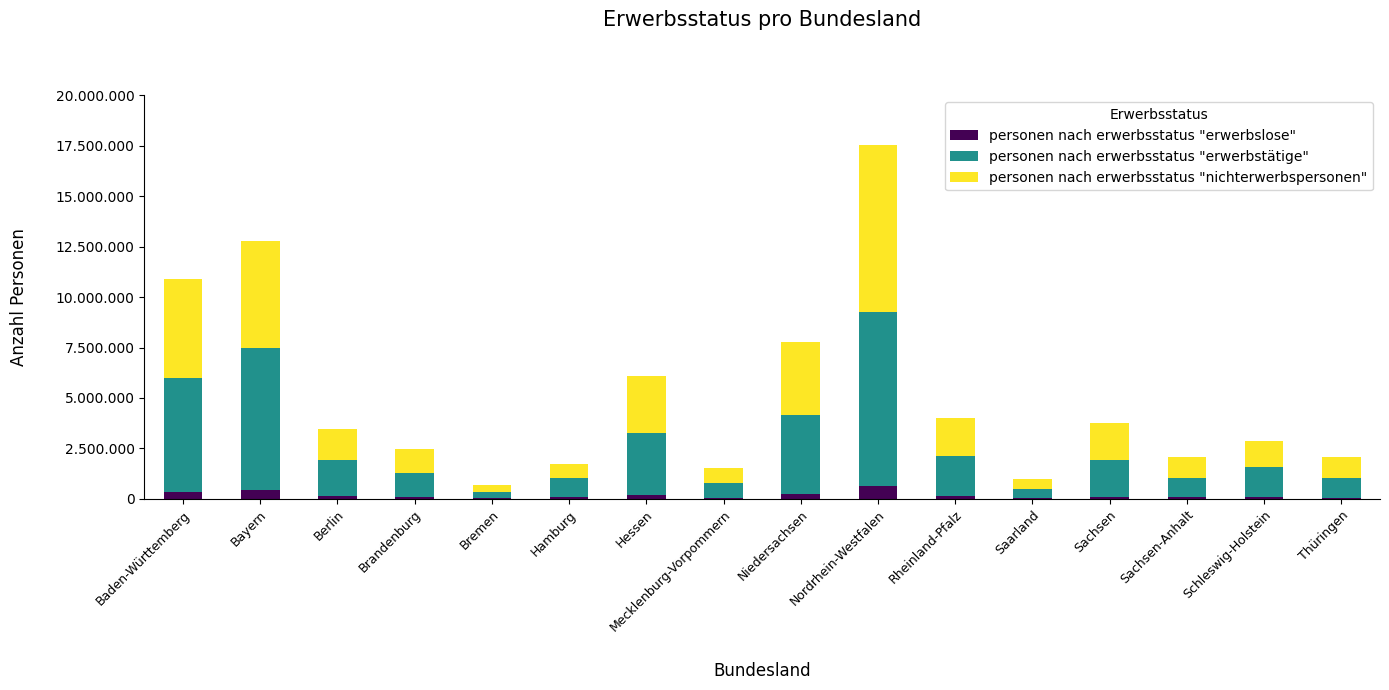

In [24]:
query = '''
SELECT 
    r.name AS bundesland,
    ad.bezeichnung AS kennzahlentyp,
    SUM(f.kennzahlenwert) AS summe
FROM 
    fct_zensus f
JOIN 
    dim_regionen r ON f.region_id = r.region_id
JOIN 
    dim_attribute_details ad ON f.attribut_id = ad.attribut_id
WHERE 
    r.regionalebene = 'Land' AND
    f.entitaet_id = 5 AND
    f.time_id = 1 AND
    ad.detail LIKE '%%insgesamt%%' AND  -- Nur die Gesamtsummen berücksichtigen
    ad.bezeichnung IN (
        'personen nach erwerbsstatus "erwerbstätige"', 
        'personen nach erwerbsstatus "erwerbslose"', 
        'personen nach erwerbsstatus "nichterwerbspersonen"'
    )
GROUP BY 
    r.name, ad.bezeichnung
ORDER BY 
    r.name, ad.bezeichnung;
'''
# Daten aus der SQL-Abfrage einlesen
data = pd.read_sql(query, engine)

# Überprüfen, ob Daten zurückgegeben wurden
if data.empty:
    print("Das DataFrame 'data' ist leer.")
else:
    # Daten für das Stacked Bar Chart vorbereiten
    pivot_data = data.pivot(index='bundesland', columns='kennzahlentyp', values='summe').fillna(0)

    # Setze Locale auf Deutsch, um das Zahlenformat zu ändern
    locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

    # Tausendertrennzeichen mit Punkt festlegen (deutsche Formatierung)
    def format_with_thousand_sep(value):
        return '{:,.0f}'.format(value).replace(',', '.')

    fig, ax = plt.subplots(figsize=(14, 7))

    # Gestapeltes Balkendiagramm plotten
    bars = pivot_data.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

    # Achsen und Titel anpassen
    ax.set_xlabel('Bundesland', fontsize=12, labelpad=20)
    ax.set_ylabel('Anzahl Personen', fontsize=12, labelpad=20)  # Abstand zur Y-Achse vergrößern
    ax.set_title('Erwerbsstatus pro Bundesland', fontsize=15, pad=50)  # Mehr Abstand zum Titel

    # Anpassung der x-Ticks: Position und Rotation
    ax.set_xticks(range(len(pivot_data.index)))
    ax.set_xticklabels(pivot_data.index, rotation=45, ha='right', fontsize=9, rotation_mode='anchor')  # Rechtsbündig und im Winkel anzeigen

    # Entfernen der oberen und rechten Ränder
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Y-Achse dynamisch skalieren und Tausendertrennzeichen mit Punkt setzen
    max_y_value = pivot_data.max().max()
    ax.set_ylim(0, max_y_value * 2.7)
    ax.set_ylim(0, 20000000) 
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_with_thousand_sep(x)))  # Punkt als Tausendertrennzeichen

    # Legende in die obere rechte Ecke verschieben
    ax.legend(title='Erwerbsstatus', fontsize=10, loc='upper right')

    # Summenwerte über den Balken anzeigen, mit einem Punkt als Tausendertrennzeichen
    # for p in ax.patches:
    #     height = p.get_height()
    #     if height > 0:
    #         formatted_value = format_with_thousand_sep(height)
    #         ax.annotate(formatted_value, 
    #                     (p.get_x() + p.get_width() / 2., p.get_y() + height), 
    #                     ha='center', va='bottom', xytext=(0, 5), 
    #                     textcoords='offset points', fontsize=9)

    # Mehr Platz oben für die Werte über den Balken
    plt.subplots_adjust(top=0.85)  # Mehr Platz oberhalb des Plots für die Balkenwerte

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()


2. Erwerbstätige Personen nach Altersklassen in Deutschland pro Bundesland

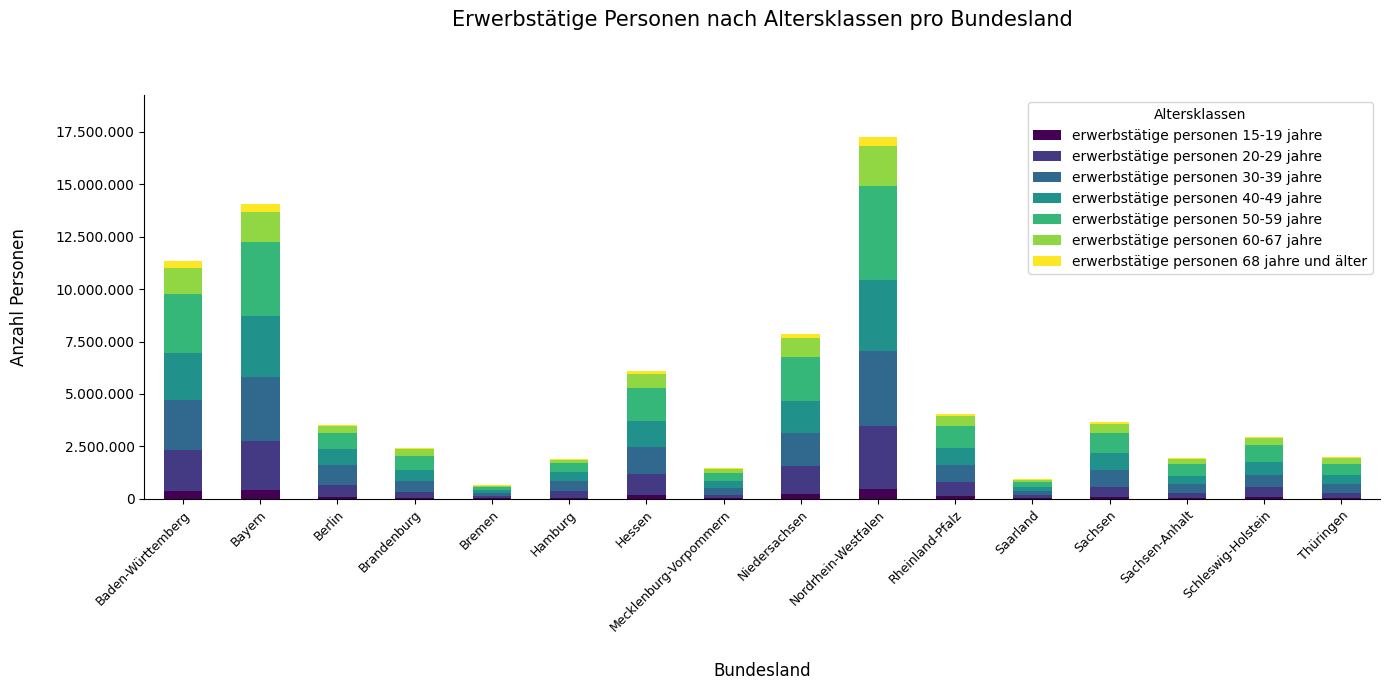

In [25]:
query_altersklassen = """
SELECT 
    r.name AS bundesland,
    ad.bezeichnung AS altersklasse,
    SUM(f.kennzahlenwert) AS summe
FROM 
    fct_zensus f
JOIN 
    dim_regionen r ON f.region_id = r.region_id
JOIN 
    dim_attribute_details ad ON f.attribut_id = ad.attribut_id
WHERE 
    r.regionalebene = 'Land' AND
    f.entitaet_id = 6 AND
    f.time_id = 1
GROUP BY 
    r.name, ad.bezeichnung
ORDER BY 
    r.name, ad.bezeichnung;
"""

# Daten aus der SQL-Abfrage einlesen
data_altersklassen = pd.read_sql(query_altersklassen, engine)

# Überprüfen, ob Daten zurückgegeben wurden
if data_altersklassen.empty:
    print("Das DataFrame 'data_altersklassen' ist leer.")
else:
    # Daten für das Stacked Bar Chart vorbereiten
    pivot_data_altersklassen = data_altersklassen.pivot(index='bundesland', columns='altersklasse', values='summe').fillna(0)

    # Setze Locale auf Deutsch, um das Zahlenformat zu ändern
    locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

    # Tausendertrennzeichen mit Punkt festlegen (deutsche Formatierung)
    def format_with_thousand_sep(value):
        return '{:,.0f}'.format(value).replace(',', '.')

    fig, ax = plt.subplots(figsize=(14, 7))

    # Gestapeltes Balkendiagramm plotten
    bars_altersklassen = pivot_data_altersklassen.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

    # Achsen und Titel anpassen
    ax.set_xlabel('Bundesland', fontsize=12, labelpad=20)
    ax.set_ylabel('Anzahl Personen', fontsize=12, labelpad=20)  # Abstand zur Y-Achse vergrößern
    ax.set_title('Erwerbstätige Personen nach Altersklassen pro Bundesland', fontsize=15, pad=50)  # Mehr Abstand zum Titel

    # Anpassung der x-Ticks: Position und Rotation
    ax.set_xticks(range(len(pivot_data_altersklassen.index)))
    ax.set_xticklabels(pivot_data_altersklassen.index, rotation=45, ha='right', fontsize=9, rotation_mode='anchor')  # Rechtsbündig und im Winkel anzeigen

    # Entfernen der oberen und rechten Ränder
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Y-Achse dynamisch skalieren und Tausendertrennzeichen mit Punkt setzen
    max_y_value_altersklassen = pivot_data_altersklassen.max().max()
    ax.set_ylim(0, max_y_value_altersklassen * 4.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format_with_thousand_sep(x)))  # Punkt als Tausendertrennzeichen

    # Legende in die obere rechte Ecke verschieben
    ax.legend(title='Altersklassen', fontsize=10, loc='upper right')

    # Mehr Platz oben für die Werte über den Balken
    plt.subplots_adjust(top=0.85)  # Mehr Platz oberhalb des Plots für die Balkenwerte

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()